# Datojen haku ja esikäsittely

In [1]:
from set_path import set_path
mainpath, path = set_path('areadata')

In [2]:
from read_and_prepare_data import read_and_prepare_data
stat, post, kunta_stat, vaalidata = read_and_prepare_data(path)

read_and_prepare_data  read from file
read_post_muncipalities  read from file


In [3]:
from selected_cols import selected_cols
numeric_features, categorical_features = selected_cols(largeset=False, parties=True)

load model
Number of clusters: 7 Silhouette Coefficient: 0.153 Calinski Harabaz Index: 283
3    943
1    884
5    346
2    328
0    187
6    150
4    132
Name: cluster, dtype: int64


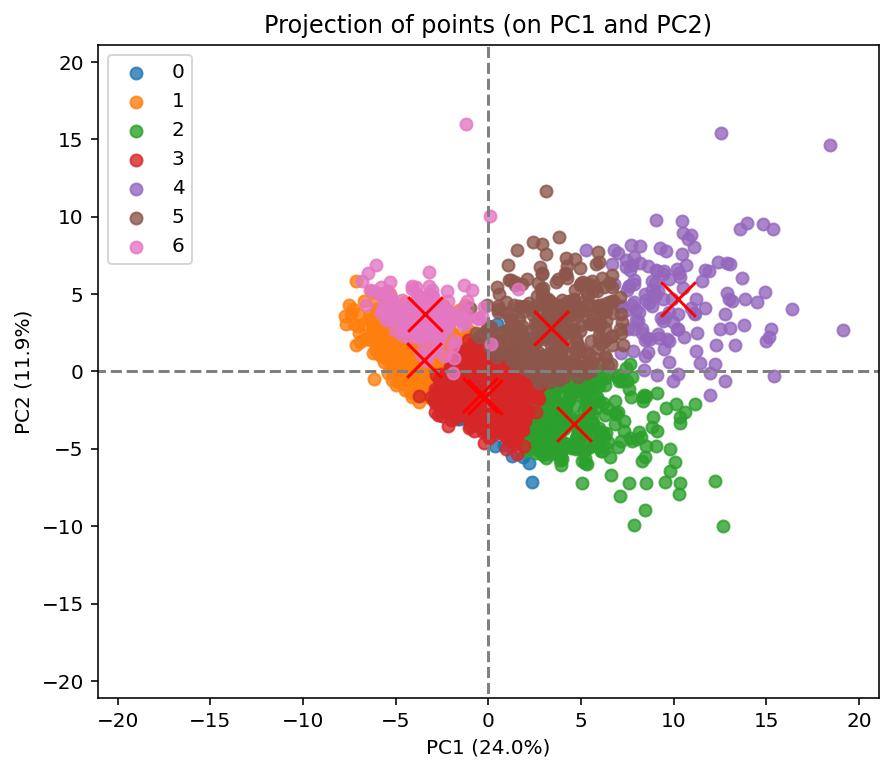

In [4]:
from sklearn.feature_selection import  mutual_info_classif
import pandas as pd
from sklearn.cluster import KMeans
import shap

from draw_and_create_clusters import create_kmeans_clusters 
from draw_and_create_clusters import draw_clusters, display_circles, display_parallel_coordinates_centroids, display_factorial_planes

from prepare_and_scale_data import prepare_and_scale_data
from create_prediction import select_kbest
from select_columns_and_clean_data import select_columns_and_clean_data
from draw_all import draw_features

from shap_Xboost import shap_Xboost
from shap_proba_individual import print_reason, print_individual_waterfall
from shap_vals import shap_vals
from print_examples import plot_difference, create_example_df, find_most_different, show_real_share
from create_target_columns import create_target_columns
from create_new_values import create_new_values
from create_share_of_values import create_share_of_values

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.options.display.max_colwidth = 100

list_of_parties = ['VIHR', 'KOK', 'SDP', 'KD', 'KESK', 'RKP', 'PS', 'VAS']
included_col_start = 'Ääniosuus'
all_included_columns = create_target_columns(list_of_parties, included_col_start)
included_col_start = 'Äänet yhteensä lkm'
all_included_columns_2 = create_target_columns(list_of_parties, included_col_start)
share_of_votes = 'Ääniosuus'
total_votes = 'Äänet yhteensä lkm Äänioikeutetut yhteensä'


n_components = 2
n_clusters = 7
axis_ranks=  [(0,1)]
alpha = 0.8
scaled = True
silhouette_print = 0

filename_model = 'kmeans_cluster'
data, X, test, kmeans = create_kmeans_clusters(filename_model, path, stat, stat, numeric_features=numeric_features, categorical_features=categorical_features, n_clusters=n_clusters, silhouette_print=silhouette_print, scaled=scaled)

print(data['cluster'].value_counts())
display_factorial_planes(kmeans, data, X, n_components=n_components, axis_ranks=axis_ranks, labels=None, alpha=alpha)

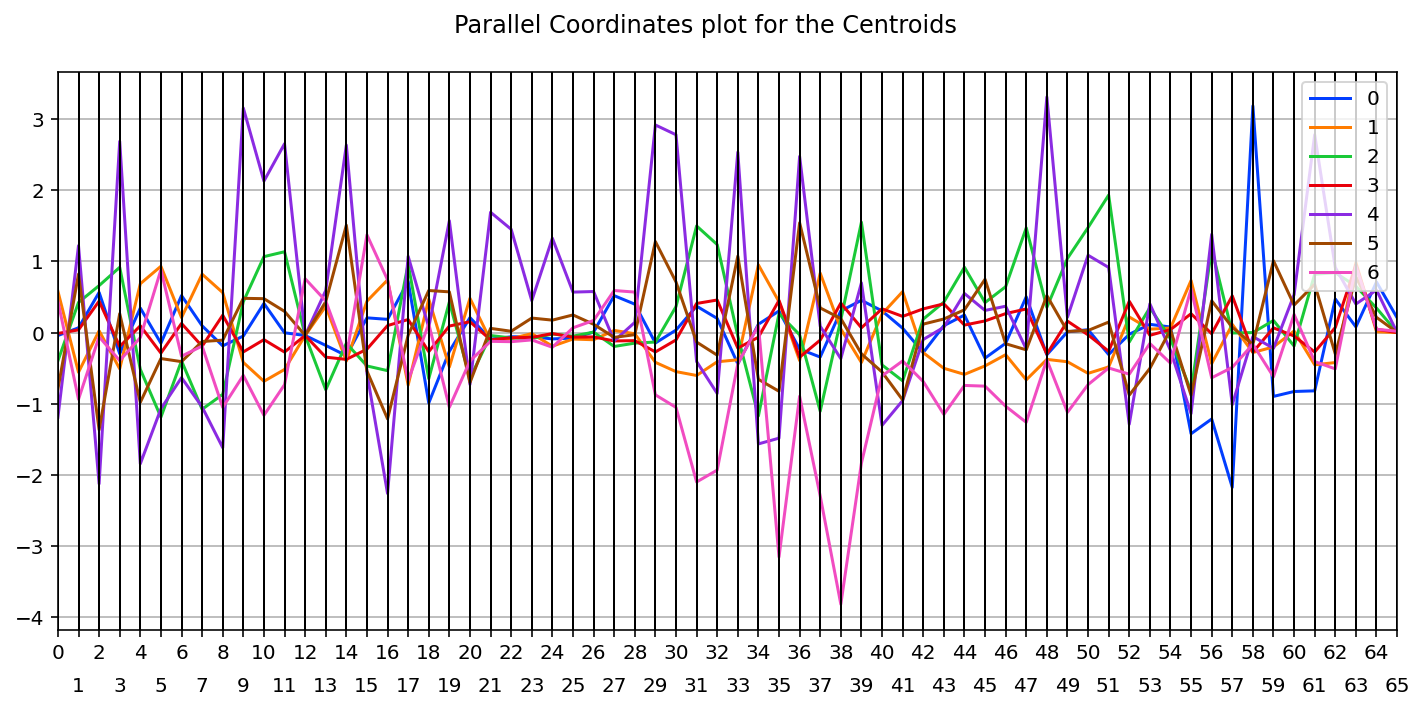

In [5]:
labels = [X.columns.get_loc(c) for c in X.columns]
centroids=display_parallel_coordinates_centroids(kmeans, labels=labels)
cols = X.columns.to_list()
cols.append('cluster')
centroids.columns = cols

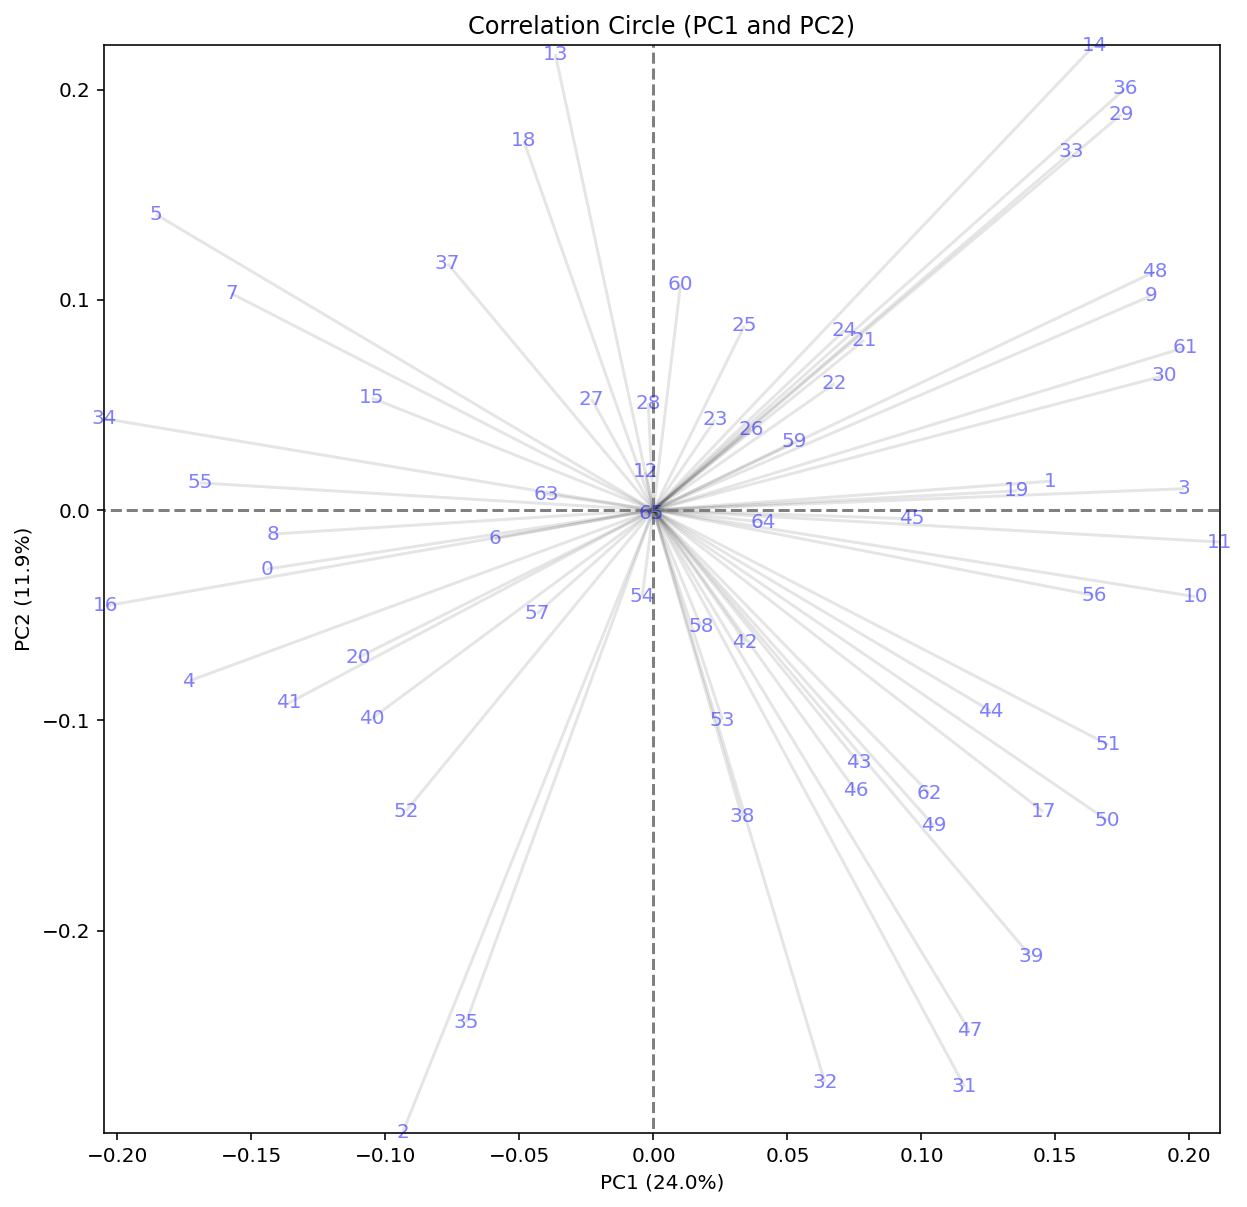

In [6]:
axis_ranks =  [(0,1)]
n_components = 2
labels = [X.columns.get_loc(c) for c in X.columns]

pcs = display_circles(X, n_components=n_components, axis_ranks=axis_ranks, labels=labels, label_rotation=0, lims=None)

In [7]:
for c in X.columns:
    print(X.columns.get_loc(c), c)

0 Miehet, 2018 (HE) osuudesta asukkaat
1 Naiset, 2018 (HE) osuudesta asukkaat
2 Asuntojen keskipinta-ala, 2018 (RA) osuus total
3 Talotyypit yhteensä 2019 Neliöhinta (EUR/m2) osuus total
4 Asumisväljyys, 2018 (TE) osuus total
5 Asukkaiden keski-ikä, 2018 (HE) osuus total
6 Postinumeroalueen pinta-ala osuus area_code
7 Perusasteen suorittaneet, 2018 (KO) osuudesta asukkaat
8 Ammatillisen tutkinnon suorittaneet, 2018 (KO) osuudesta asukkaat
9 Ylioppilastutkinnon suorittaneet, 2018 (KO) osuudesta asukkaat
10 Alemman korkeakoulututkinnon suorittaneet, 2018 (KO) osuudesta asukkaat
11 Ylemmän korkeakoulututkinnon suorittaneet, 2018 (KO) osuudesta asukkaat
12 Asukkaiden ostovoimakertymä, 2017 (HR) osuudesta asukkaat osuus total
13 Asunnot, 2018 (RA) osuudesta asukkaat
14 Kerrostaloasunnot, 2018 (RA) osuudesta asukkaat
15 Kesämökit yhteensä, 2018 (RA) osuudesta asukkaat
16 Pientaloasunnot, 2018 (RA) osuudesta asukkaat
17 Työlliset, 2017 (PT) osuudesta asukkaat
18 Työttömät, 2017 (PT) osuudesta

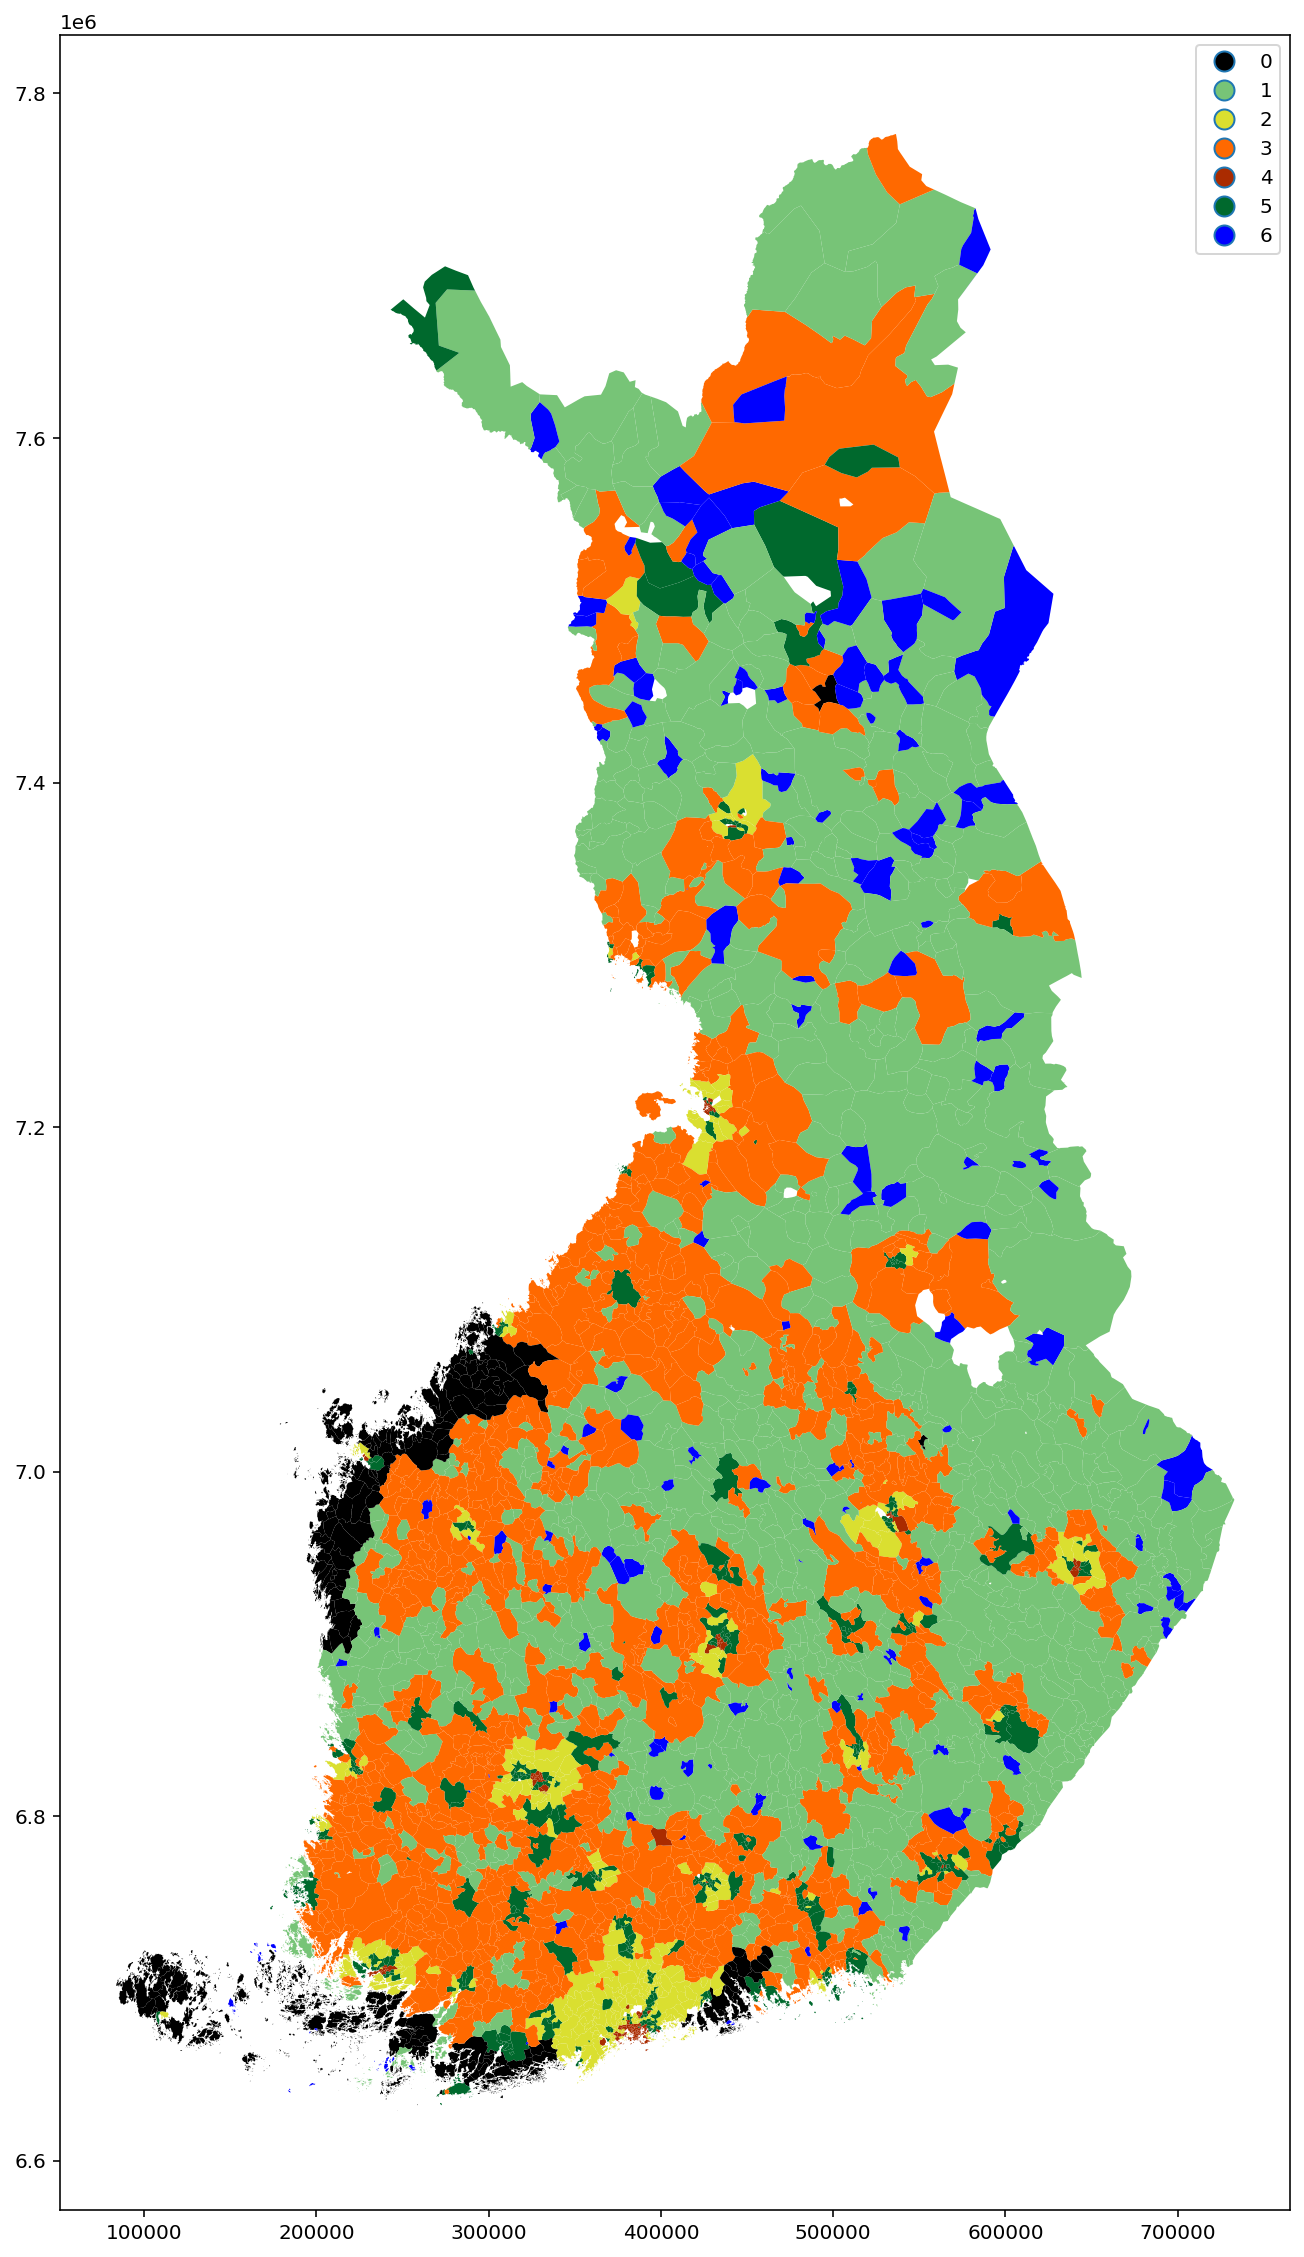

In [8]:
import geopandas
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('my cmap', ['black', 'lightgreen', 'gold',  'red',  'green', 'blue'])
draw = geopandas.GeoDataFrame(pd.DataFrame(data[['cluster', 'geometry']], dtype=object),geometry='geometry')
draw.plot(column='cluster', cmap=cmap, legend=True, figsize=(20,20))

In [9]:
import xgboost as xgb
from sklearn.feature_selection import  mutual_info_classif
from create_prediction import create_prediction

target = 'cluster'

ennustettu = "uusi" + target

#Check
#k_selected need to have correct values, if they are too large, evrything needs to be started again
k_selected = 'all'

test_size = 0.2

#Scalers attributes
kbest_score_func = mutual_info_classif
#set values to model configuration attributes

num_class = len(data['cluster'].unique()) #how many classes we are working with

metric = 'merror'
Skfold=True
Verbose = False
testing=True
scaled = False

params = {
    # Parameters that we are going to tune.
    'objective':'multi:softmax',
    'num_class' : num_class,
    'booster' : 'gbtree',
    'eval_metric' : metric
}

filename_model = 'kmeans_xgboost_cluster'
data, test, features_df, importance_df, model, params, y_pred, X_train, y_train, X_test, y_test = create_prediction(filename_model, path, data, data, target, kbest_score_func, metric, params, numeric_features, categorical_features, scaled=scaled, testing=testing)
data_no_use, X_scale, X = prepare_and_scale_data(data, pd.DataFrame(), numeric_features, categorical_features)


load model


In [10]:
filename_model = 'kmeans_mymodel_xgboost_cluster'
filename_shap =  'kmeans_shap.npz'
mymodel, shap_values, shap_interaction_values, shap_expected_value = shap_Xboost(filename_model, filename_shap, path, data, target, params, X)


load model
load shap files


In [11]:
data[data['cluster']==1][features_df['Column'].head(5).to_list()].describe()

Pientaloasunnot, 2018 (RA) osuudesta asukkaat  \
count                                     884.000000   
mean                                        0.585284   
std                                         0.088278   
min                                         0.342147   
25%                                         0.533212   
50%                                         0.578523   
75%                                         0.623417   
max                                         1.650602   

       Lapsitaloudet, 2018 (TE) osuudesta taloudet  \
count                                   884.000000   
mean                                      0.141522   
std                                       0.048979   
min                                       0.000000   
25%                                       0.111111   
50%                                       0.144061   
75%                                       0.172452   
max                                       0.300000   

       Talotyypit yhteensä 2019 Neliöhinta (EUR/m2) osuus total  \
count                                                884.000000   
mean                                                   0.600584   
std                                                    0.429868   
min                                                    0.000000   
25%                                                    0.362783   
50%                                                    0.608814   
75%                                                    0.831412   
max                                                    2.022376   

       Omistusasunnoissa asuvat taloudet, 2018 (TE) osuudesta taloudet  \
count                                                       884.000000   
mean                                                          0.877067   
std                                                           0.105557   
min                                                           0.000000   
25%                                                           0.843063   
50%                                                           0.906977   
75%                                                           0.943202   
max                                                           1.000000   

       Alimpaan tuloluokkaan kuuluvat taloudet, 2017 (TR) osuudesta taloudet  
count                                                             884.000000  
mean                                                                0.341757  
std                                                                 0.070102  
min                                                                 0.000000  
25%                                                                 0.296401  
50%                                                                 0.343374  
75%                                                                 0.384812  
max                                                                 0.603448

In [12]:
importance_df[importance_df['Importance type']==importance_df['Importance type'].unique()[0]].head(15)

Feature  \
0                  Alimpaan tuloluokkaan kuuluvat taloudet, 2017 (TR) osuudesta taloudet   
1   11.5.1.1 Asuntolainan korkomenot (TVL 58 § 2 mom.) Yhteensä Summa, euroa osuus total   
2                  Ylimpään tuloluokkaan kuuluvat taloudet, 2017 (TR) osuudesta taloudet   
3                                                                           Ääniosuus PS   
4                                    Eläkeläisten taloudet, 2018 (TE) osuudesta taloudet   
5                                                                         Ääniosuus KESK   
6                                                                         Ääniosuus VIHR   
7                                                Työttömät, 2017 (PT) osuudesta asukkaat   
8                                          Pientaloasunnot, 2018 (RA) osuudesta asukkaat   
9             Keskimmäiseen tuloluokkaan kuuluvat taloudet, 2017 (TR) osuudesta taloudet   
10                                                                         Ääniosuus RKP   
11                       Vuokra-asunnoissa asuvat taloudet, 2018 (TE) osuudesta taloudet   
12               Ylemmän korkeakoulututkinnon suorittaneet, 2018 (KO) osuudesta asukkaat   
13                     Ammatillisen tutkinnon suorittaneet, 2018 (KO) osuudesta asukkaat   
14                                           Lapsitaloudet, 2018 (TE) osuudesta taloudet   

    Score Importance type  
0    48.0          weight  
1    43.0          weight  
2    42.0          weight  
3    41.0          weight  
4    37.0          weight  
5    37.0          weight  
6    36.0          weight  
7    36.0          weight  
8    33.0          weight  
9    33.0          weight  
10   33.0          weight  
11   33.0          weight  
12   30.0          weight  
13   30.0          weight  
14   29.0          weight

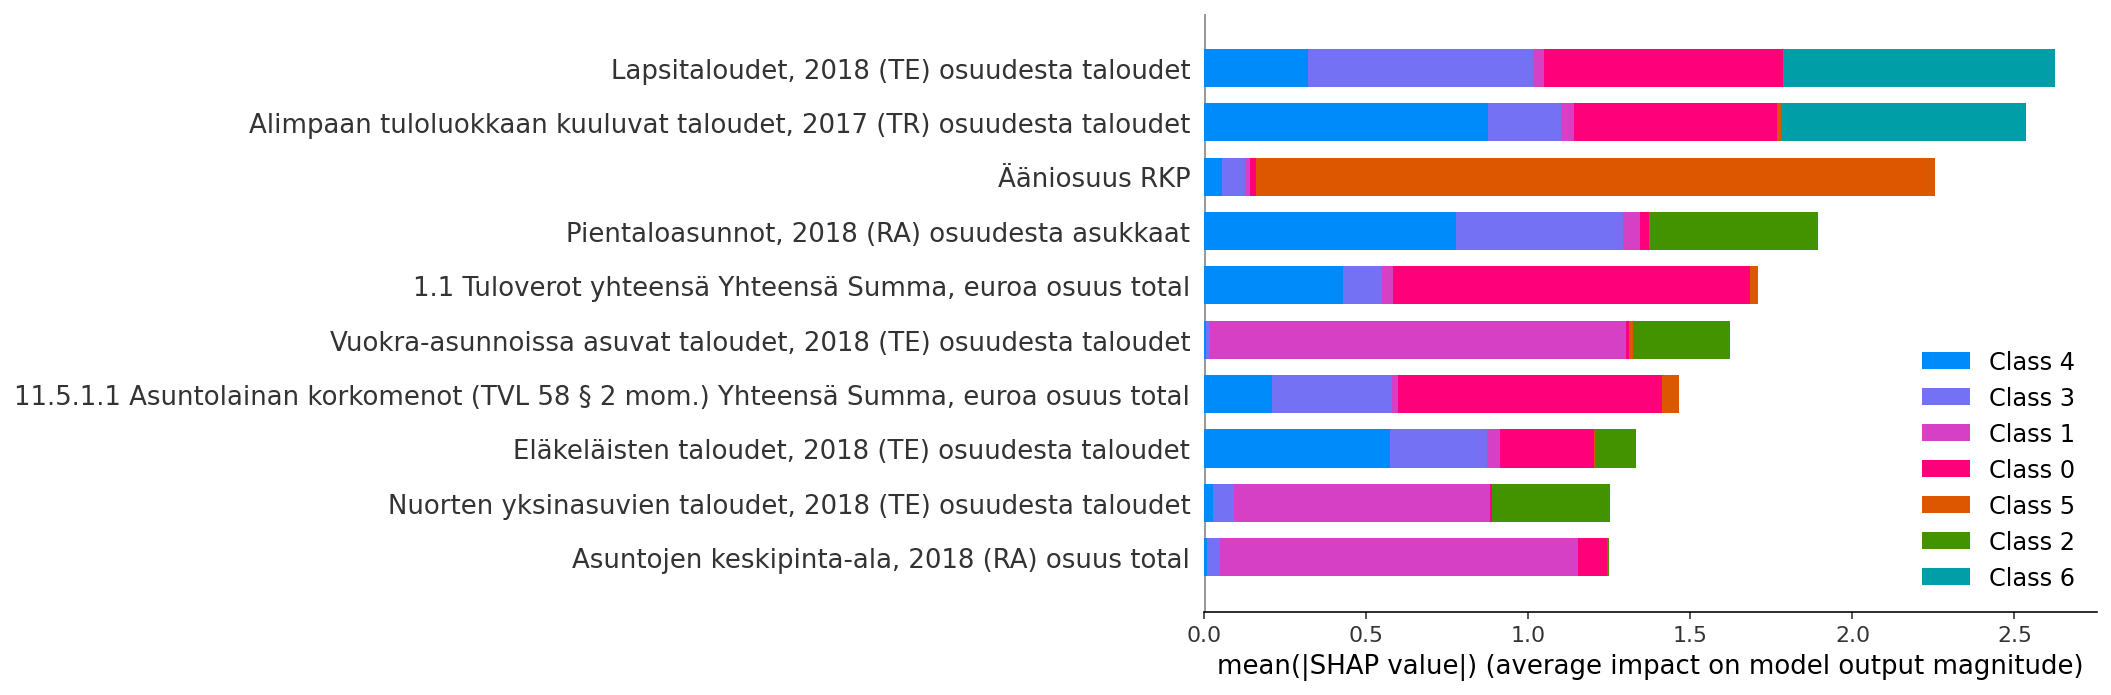

In [13]:
shap.summary_plot(shap_values, X,  max_display=10)

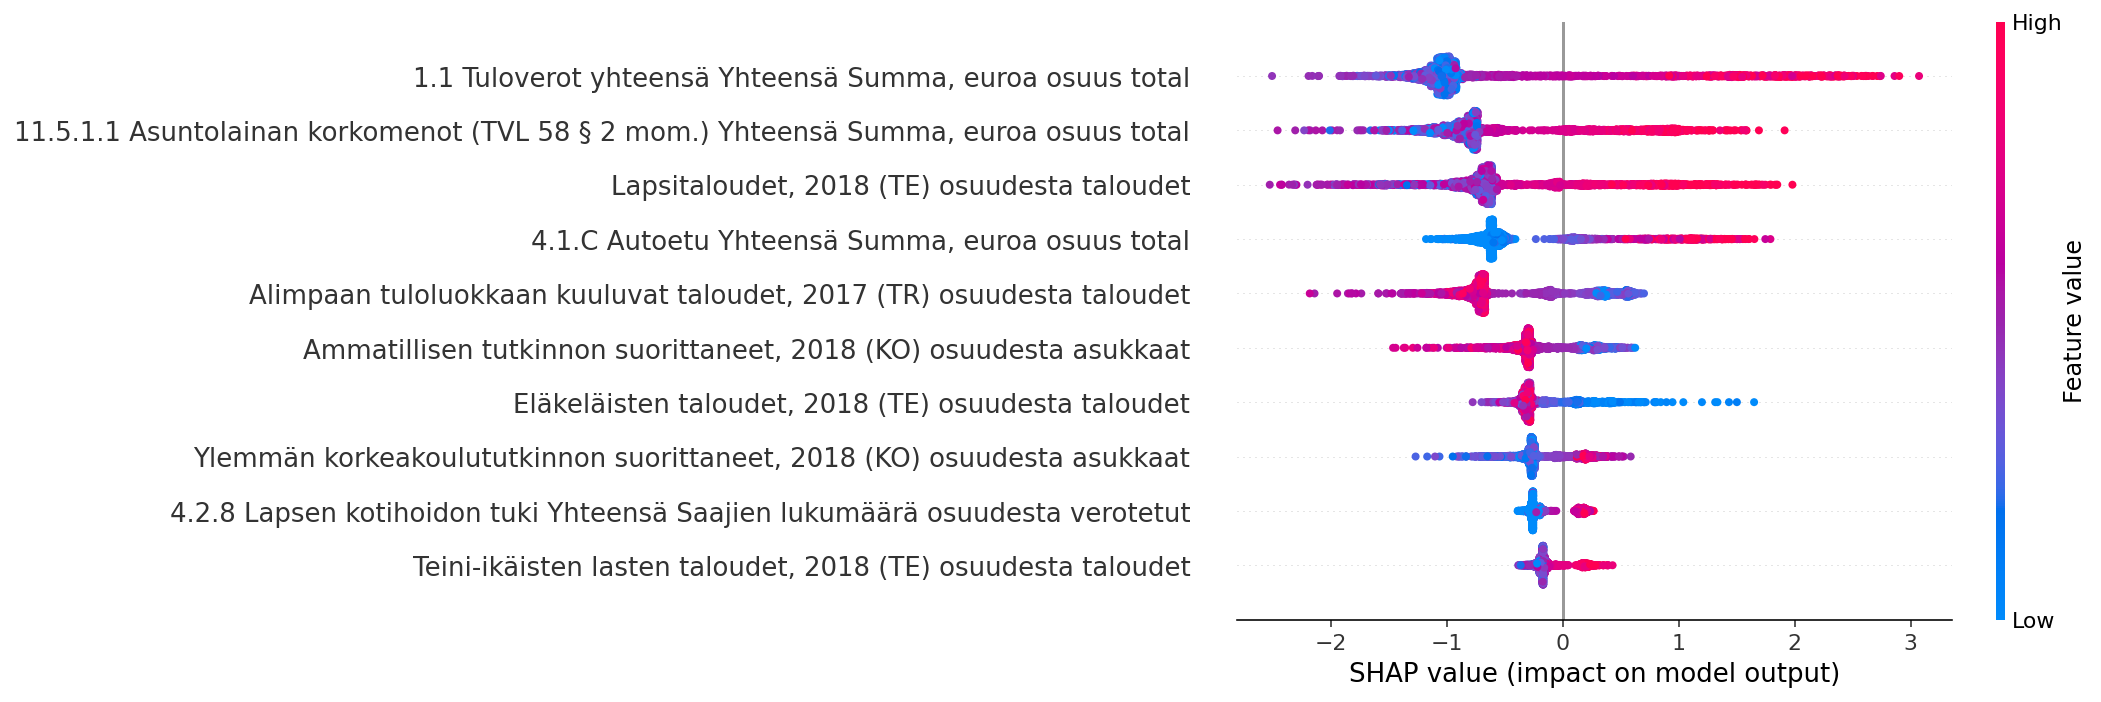

In [44]:
shap_index = 0
included_columns = []
columns = 10
scaled = False

compare_to = data[(data['cluster']) == shap_index].copy()
compare_to = create_share_of_values(compare_to)
compare_to = create_new_values(compare_to, vaalidata)

shap.summary_plot(shap_values[shap_index], X,  max_display=columns)

invalid value encountered in true_divide
invalid value encountered in true_divide


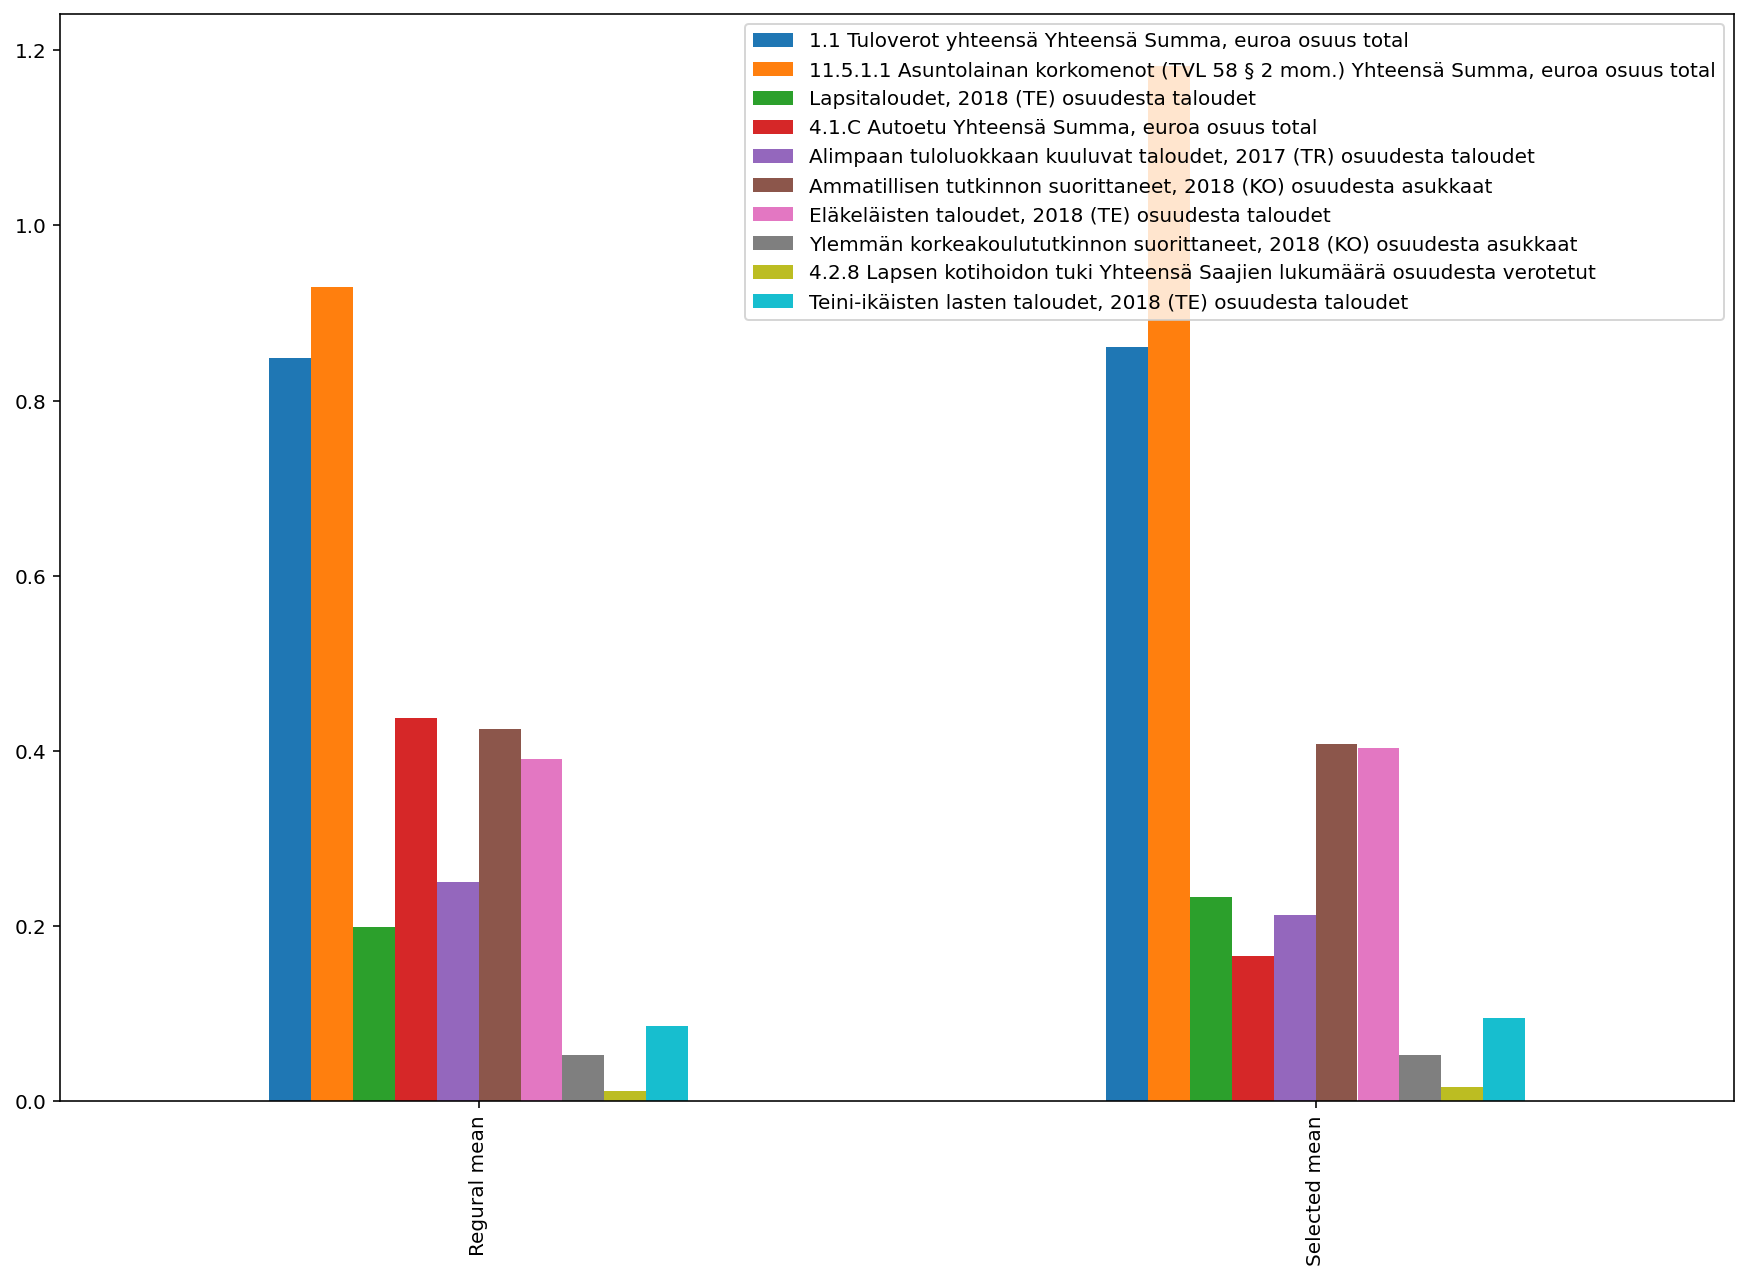

In [45]:
stats_data, k = plot_difference(data, compare_to, X, included_columns, shap_values, shap_index, col_num=columns, scaled=scaled)

invalid value encountered in true_divide
invalid value encountered in true_divide


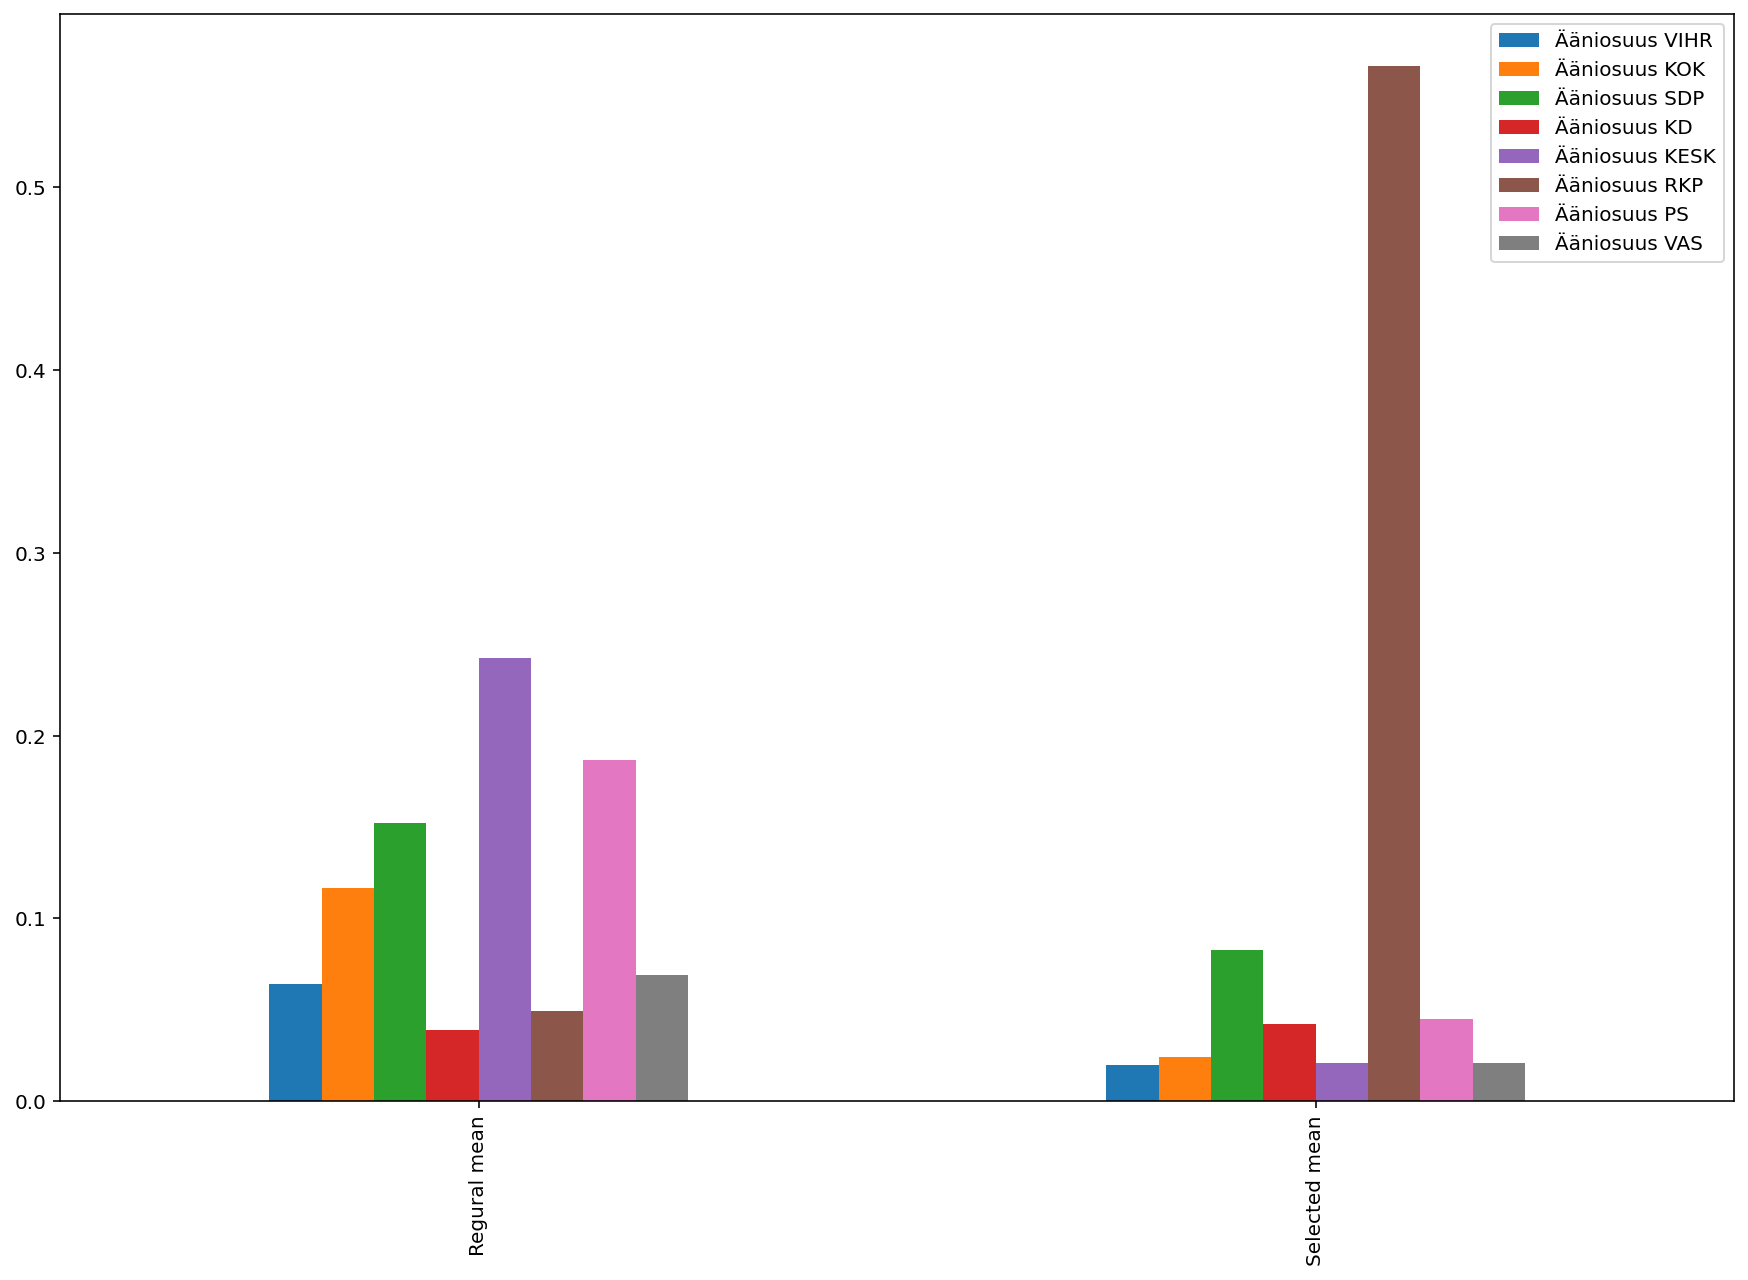

In [16]:
included_columns = all_included_columns
stats_data, k = plot_difference(data, compare_to, X, included_columns, shap_values, shap_index, col_num=0, scaled=False)

In [17]:
new = ['Postinumero','postcode_name', 'muncipality_name','Asukkaat yhteensä, 2018 (HE)', 'Suurin_puolue']
new_df, k2, col_list = create_example_df(compare_to, X, new, shap_index, shap_values, col_num=columns)
new_df.sample(5)

Postinumero postcode_name muncipality_name  Asukkaat yhteensä, 2018 (HE)  \
1894       64210         KALAX           Närpes                         429.0   
777        25700         KEMIÖ      Kemiönsaari                        2334.0   
675        23390          INIÖ         Parainen                         195.0   
332        07920       LOVIISA          Loviisa                        1399.0   
783        25830   VÄSTANFJÄRD      Kemiönsaari                         481.0   

     Suurin_puolue  \
1894           RKP   
777            RKP   
675            RKP   
332            RKP   
783            RKP   

      Ammatillisen tutkinnon suorittaneet, 2018 (KO) osuudesta asukkaat  \
1894                                                           0.414918   
777                                                            0.409169   
675                                                            0.405128   
332                                                            0.405289   
783                                                            0.444906   

      Ylemmän korkeakoulututkinnon suorittaneet, 2018 (KO) osuudesta asukkaat  \
1894                                                                 0.046620   
777                                                                  0.044987   
675                                                                  0.051282   
332                                                                  0.046462   
783                                                                  0.051975   

      Lapsitaloudet, 2018 (TE) osuudesta taloudet  \
1894                                     0.312849   
777                                      0.208763   
675                                      0.092784   
332                                      0.192701   
783                                      0.168776   

      Teini-ikäisten lasten taloudet, 2018 (TE) osuudesta taloudet  \
1894                                                      0.117318   
777                                                       0.094502   
675                                                       0.030928   
332                                                       0.093431   
783                                                       0.088608   

      Eläkeläisten taloudet, 2018 (TE) osuudesta taloudet  \
1894                                             0.391061   
777                                              0.448454   
675                                              0.597938   
332                                              0.424818   
783                                              0.459916   

      Alimpaan tuloluokkaan kuuluvat taloudet, 2017 (TR) osuudesta taloudet  \
1894                                                               0.145251   
777                                                                0.270619   
675                                                                0.268041   
332                                                                0.205839   
783                                                                0.274262   

      4.2.8 Lapsen kotihoidon tuki Yhteensä Saajien lukumäärä osuudesta verotetut  \
1894                                                                     0.000000   
777                                                                      0.022265   
675                                                                      0.000000   
332                                                                      0.000000   
783                                                                      0.000000   

      11.5.1.1 Asuntolainan korkomenot (TVL 58 § 2 mom.) Yhteensä Summa, euroa osuus total  \
1894                                                                              1.443071   
777                                                                               1.119773   
675                                                                     

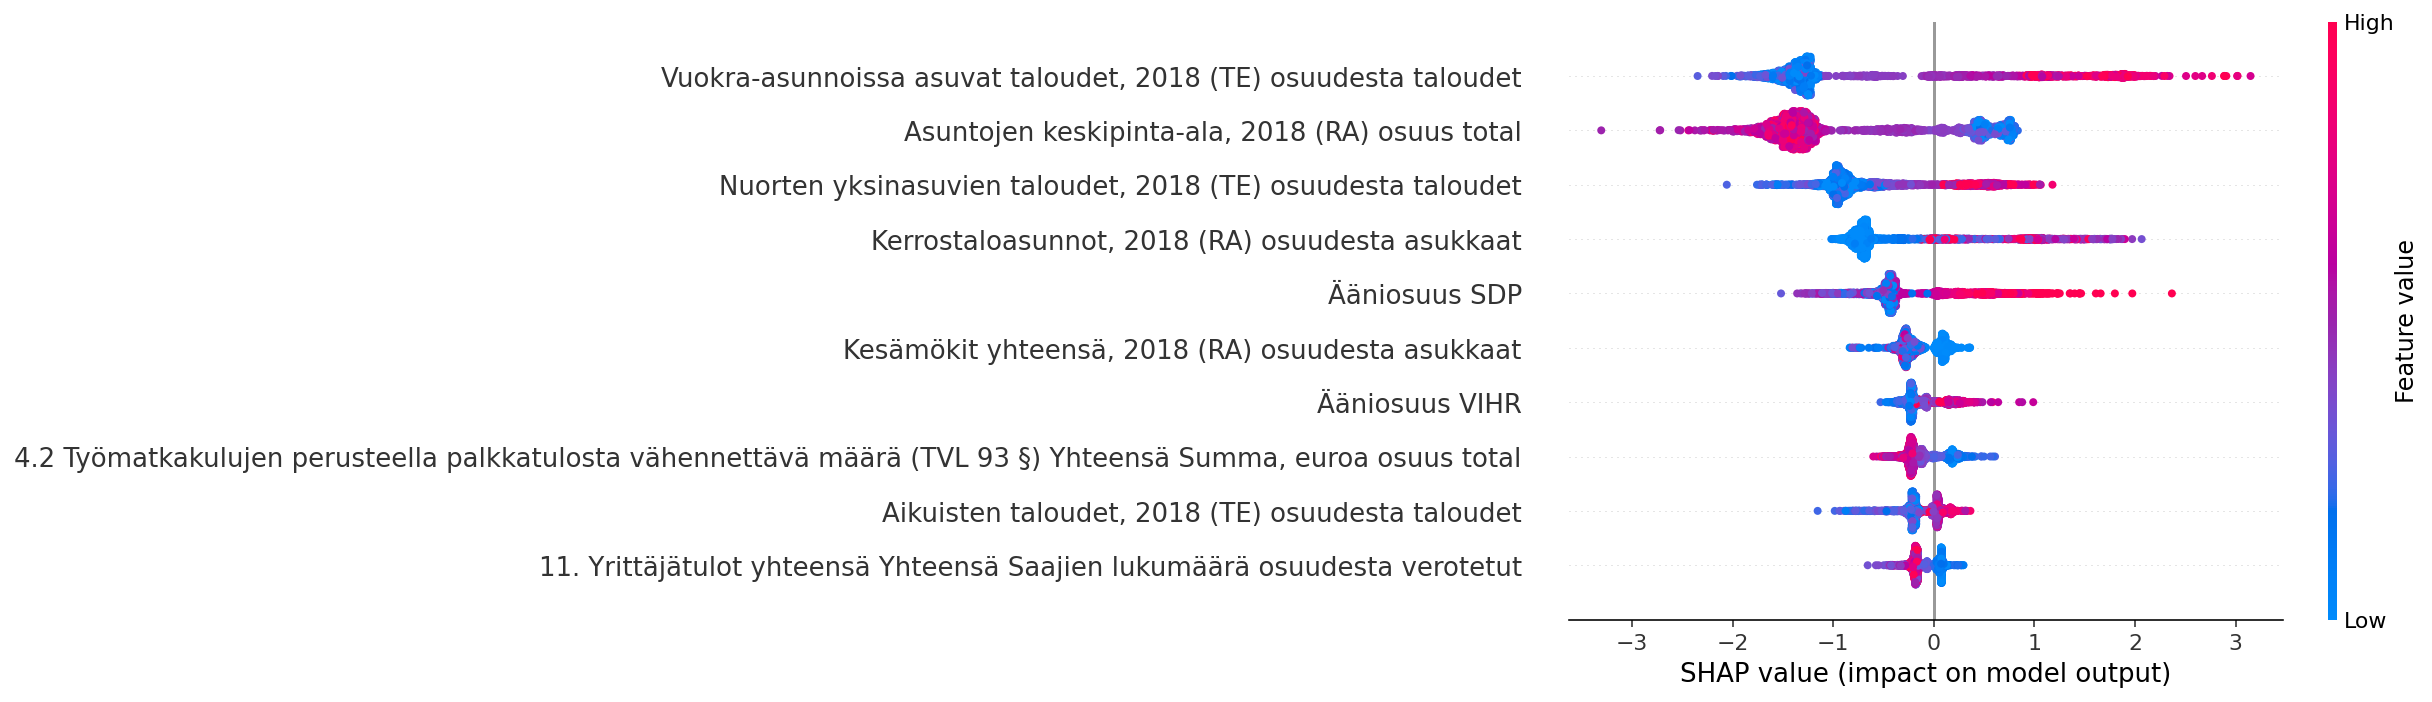

In [46]:
shap_index = 1
included_columns = []
columns = 10
scaled = False

compare_to = data[(data['cluster']) == shap_index].copy()
compare_to = create_share_of_values(compare_to)
compare_to = create_new_values(compare_to, vaalidata)

shap.summary_plot(shap_values[shap_index], X,  max_display=columns)

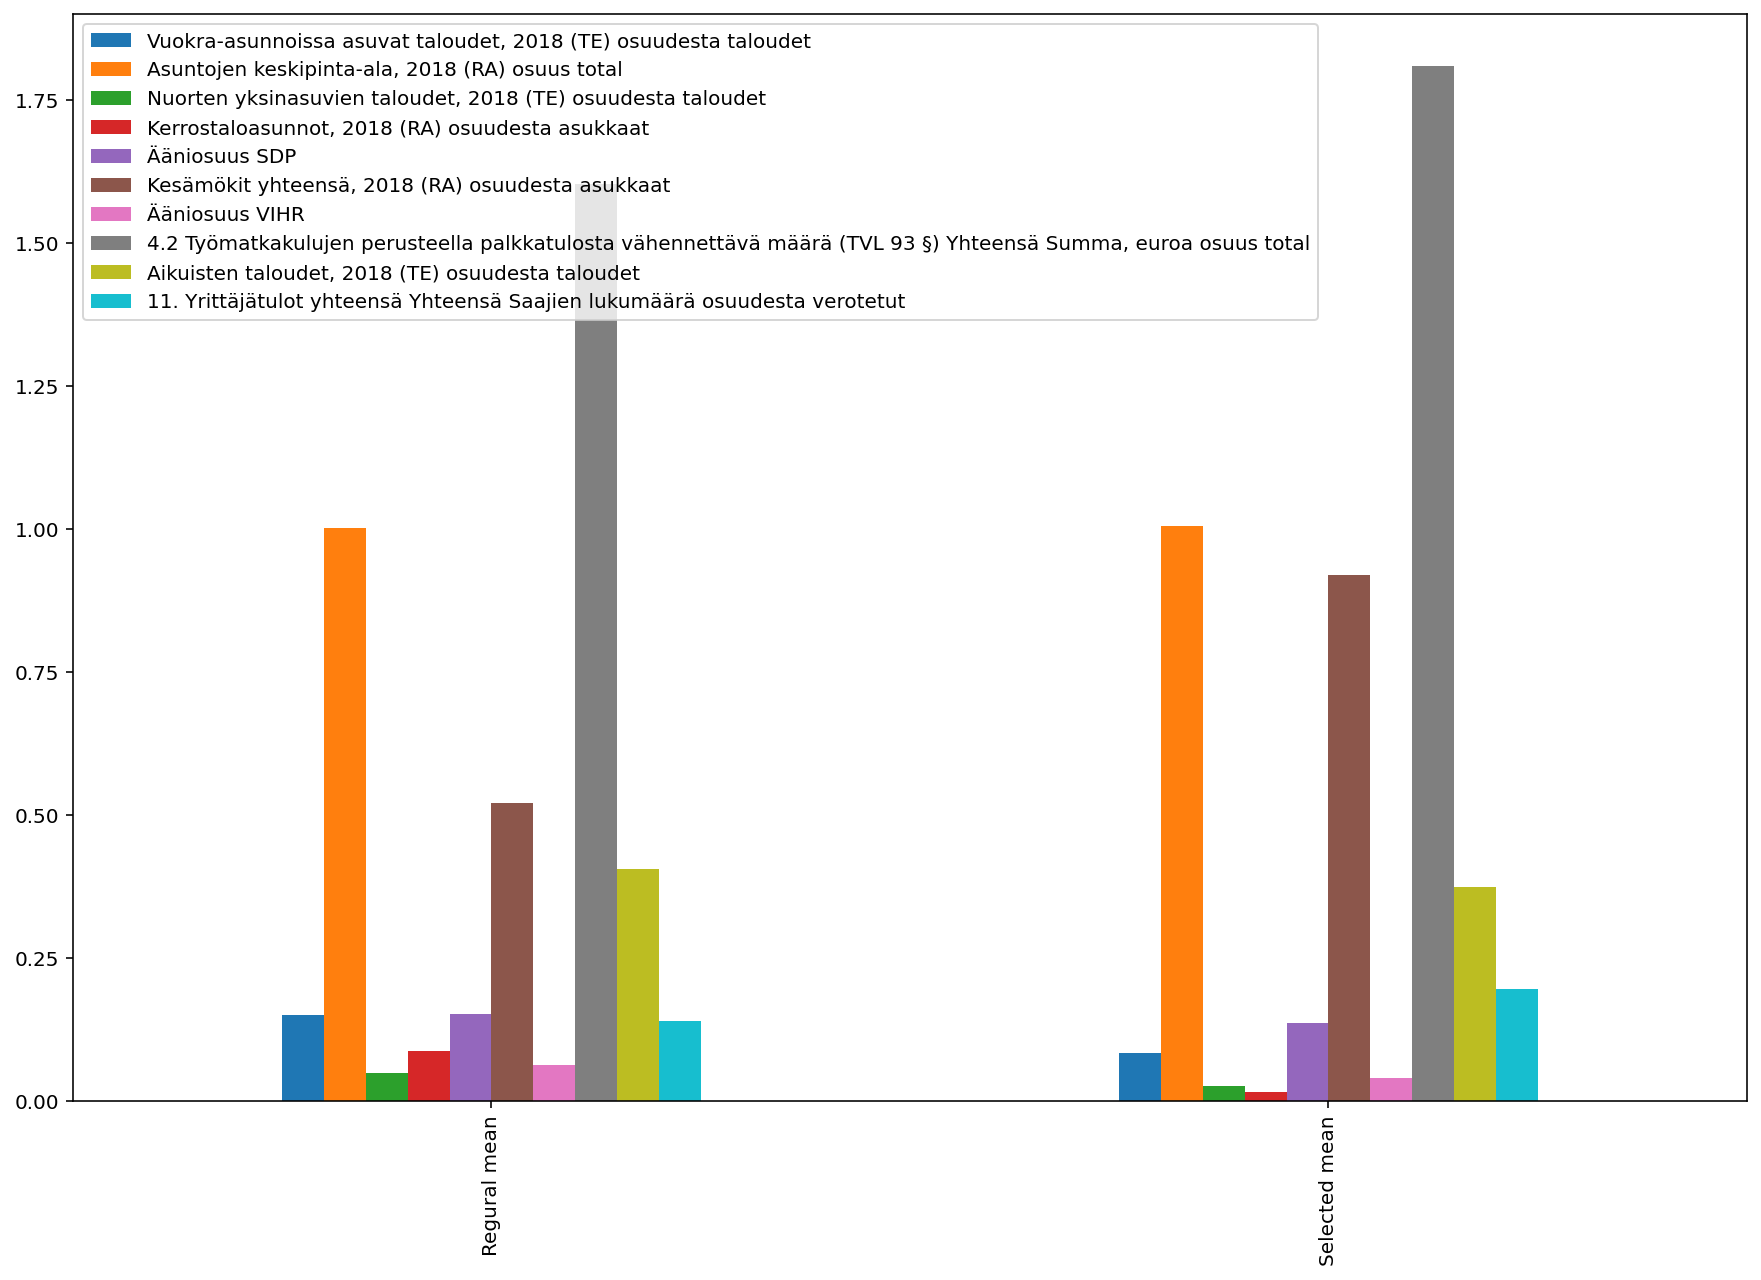

In [47]:
stats_data, k = plot_difference(data, compare_to, X, included_columns, shap_values, shap_index, col_num=columns, scaled=scaled)

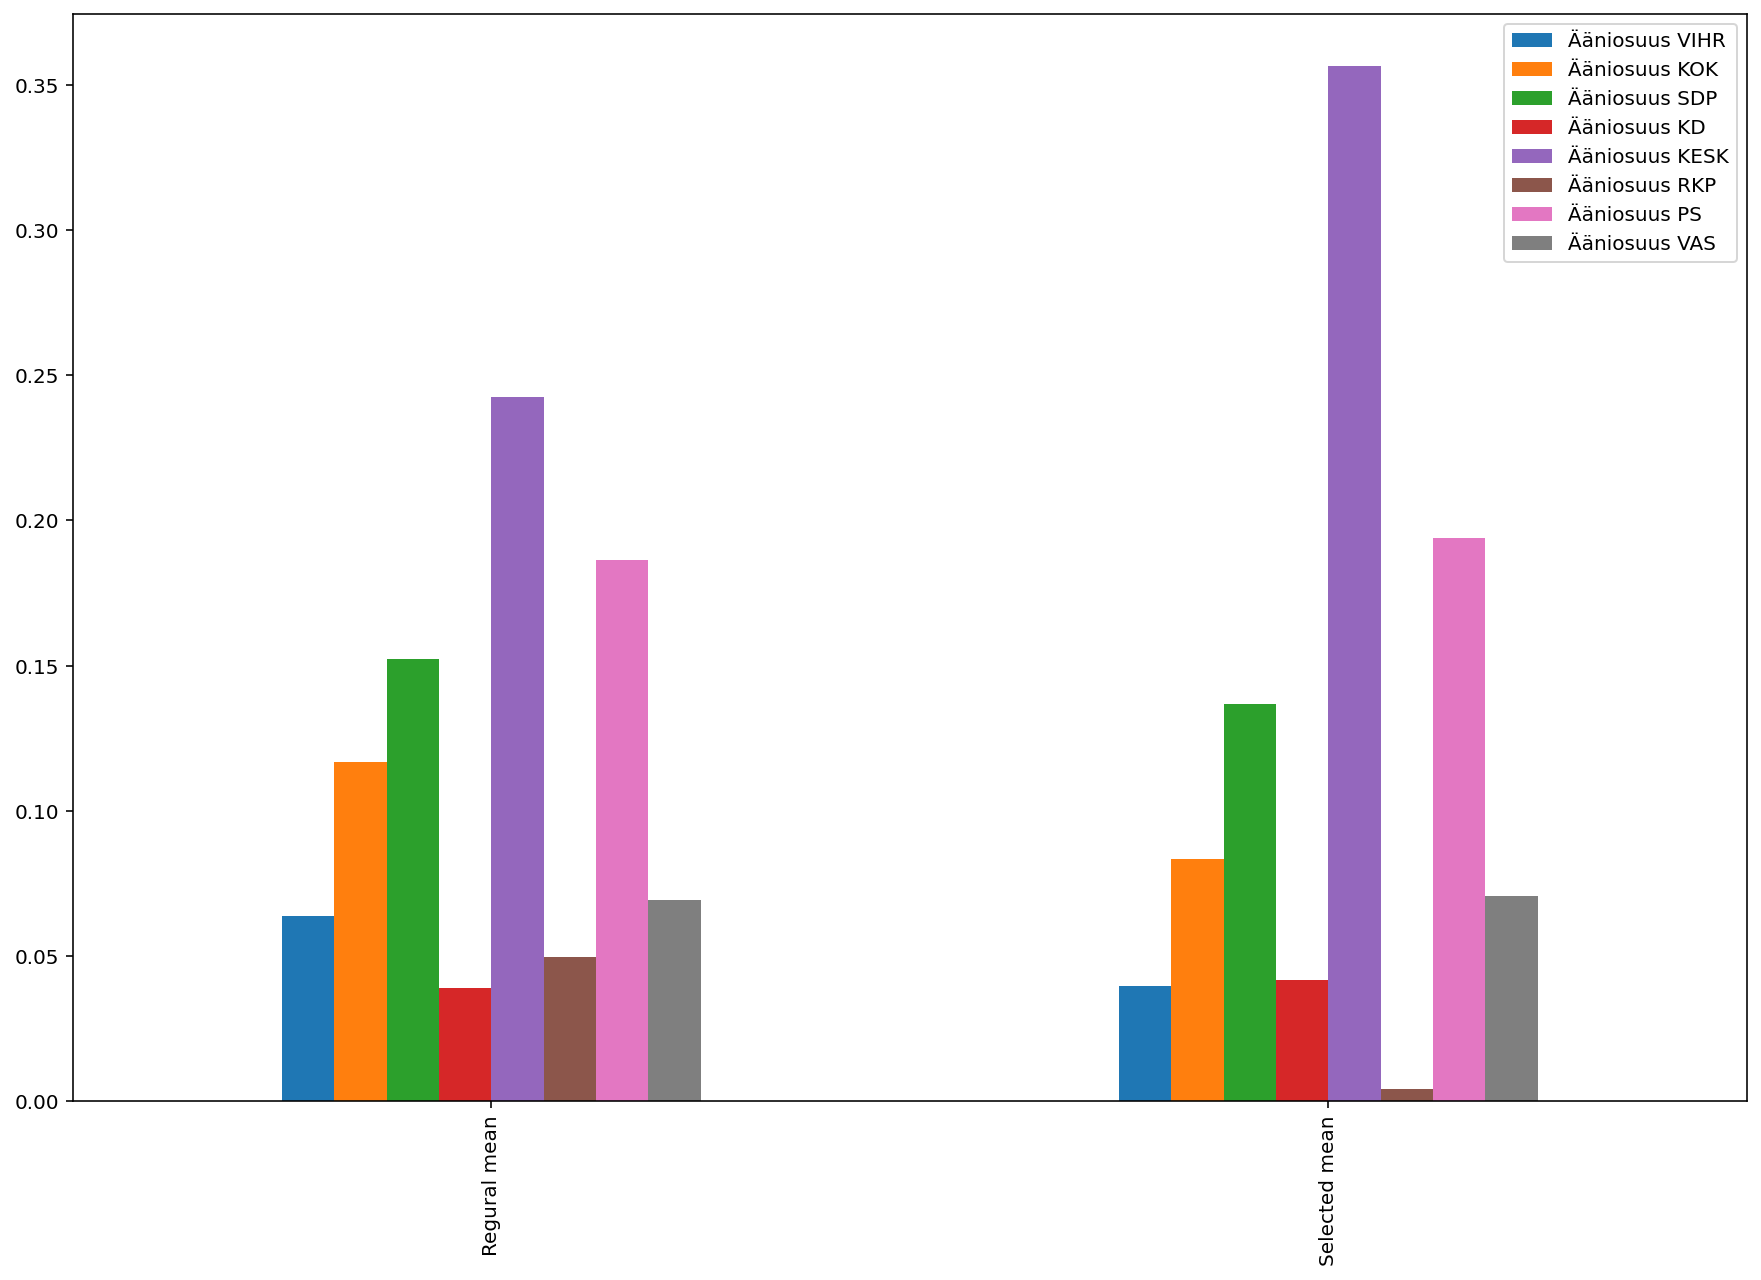

In [48]:
included_columns = all_included_columns
stats_data, k = plot_difference(data, compare_to, X, included_columns, shap_values, shap_index, col_num=0, scaled=False)

In [49]:
new = ['Postinumero','postcode_name', 'muncipality_name','Asukkaat yhteensä, 2018 (HE)', 'Suurin_puolue']
new_df, k2, col_list = create_example_df(compare_to, X, new, shap_index, shap_values, col_num=columns)
new_df.sample(5)

Postinumero postcode_name muncipality_name  Asukkaat yhteensä, 2018 (HE)  \
1779       61920    NUMMIKOSKI        Kauhajoki                          63.0   
2818       97510     VIKAJÄRVI        Rovaniemi                         176.0   
2163       74470      PALOINEN       Lapinlahti                         164.0   
2220       74390    LAAKAJÄRVI          Sotkamo                          62.0   
536        17800     KUHMOINEN        Kuhmoinen                        1764.0   

     Suurin_puolue  Asuntojen keskipinta-ala, 2018 (RA) osuus total  \
1779          KESK                                         1.027100   
2818          KESK                                         0.955686   
2163          KESK                                         1.017648   
2220          KESK                                         1.091163   
536           KESK                                         0.834913   

      Kerrostaloasunnot, 2018 (RA) osuudesta asukkaat  \
1779                                         0.000000   
2818                                         0.000000   
2163                                         0.000000   
2220                                         0.000000   
536                                          0.175737   

      Kesämökit yhteensä, 2018 (RA) osuudesta asukkaat  \
1779                                          0.206349   
2818                                          0.982955   
2163                                          0.945122   
2220                                          1.258065   
536                                           0.841837   

      Nuorten yksinasuvien taloudet, 2018 (TE) osuudesta taloudet  \
1779                                                     0.066667   
2818                                                     0.032258   
2163                                                     0.051948   
2220                                                     0.030303   
536                                                      0.045090   

      Aikuisten taloudet, 2018 (TE) osuudesta taloudet  \
1779                                          0.500000   
2818                                          0.462366   
2163                                          0.428571   
2220                                          0.454545   
536                                           0.343687   

      Vuokra-asunnoissa asuvat taloudet, 2018 (TE) osuudesta taloudet  \
1779                                                         0.033333   
2818                                                         0.182796   
2163                                                         0.000000   
2220                                                         0.000000   
536                                                          0.247495   

      11. Yrittäjätulot yhteensä Yhteensä Saajien lukumäärä osuudesta verotetut  \
1779                                                                   0.000000   
2818                                                                   0.140244   
2163                                                                   0.268116   
2220                                                                   0.000000   
536                                                                    0.150978   

      4.2 Työmatkakulujen perusteella palkkatulosta vähennettävä määrä (TVL 93 §) Yhteensä Summa, euroa osuus total  \
1779                                                                                             1.869226             
2818                                                                                             2.081057             
2163                                                                                             3.376183             
2220                                                                                             3.969684             
536                                                                                              1.093

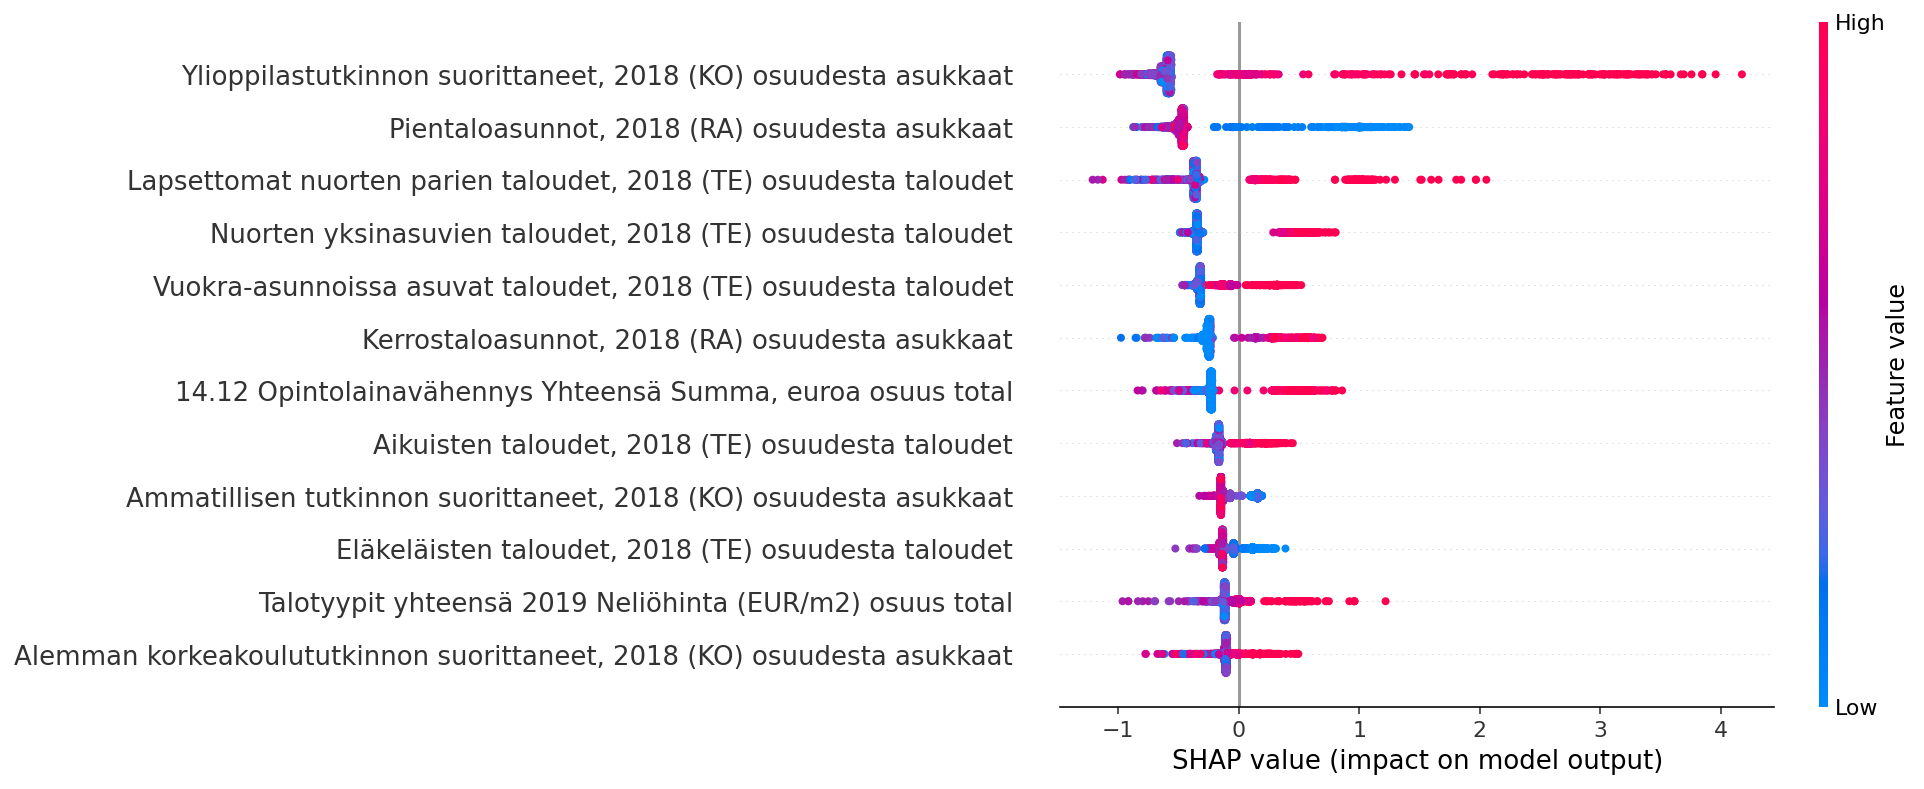

In [50]:
shap_index = 2
included_columns = []
columns = 12
scaled = False

compare_to = data[(data['cluster']) == shap_index].copy()
compare_to = create_share_of_values(compare_to)
compare_to = create_new_values(compare_to, vaalidata)

shap.summary_plot(shap_values[shap_index], X,  max_display=columns)

invalid value encountered in true_divide
invalid value encountered in true_divide


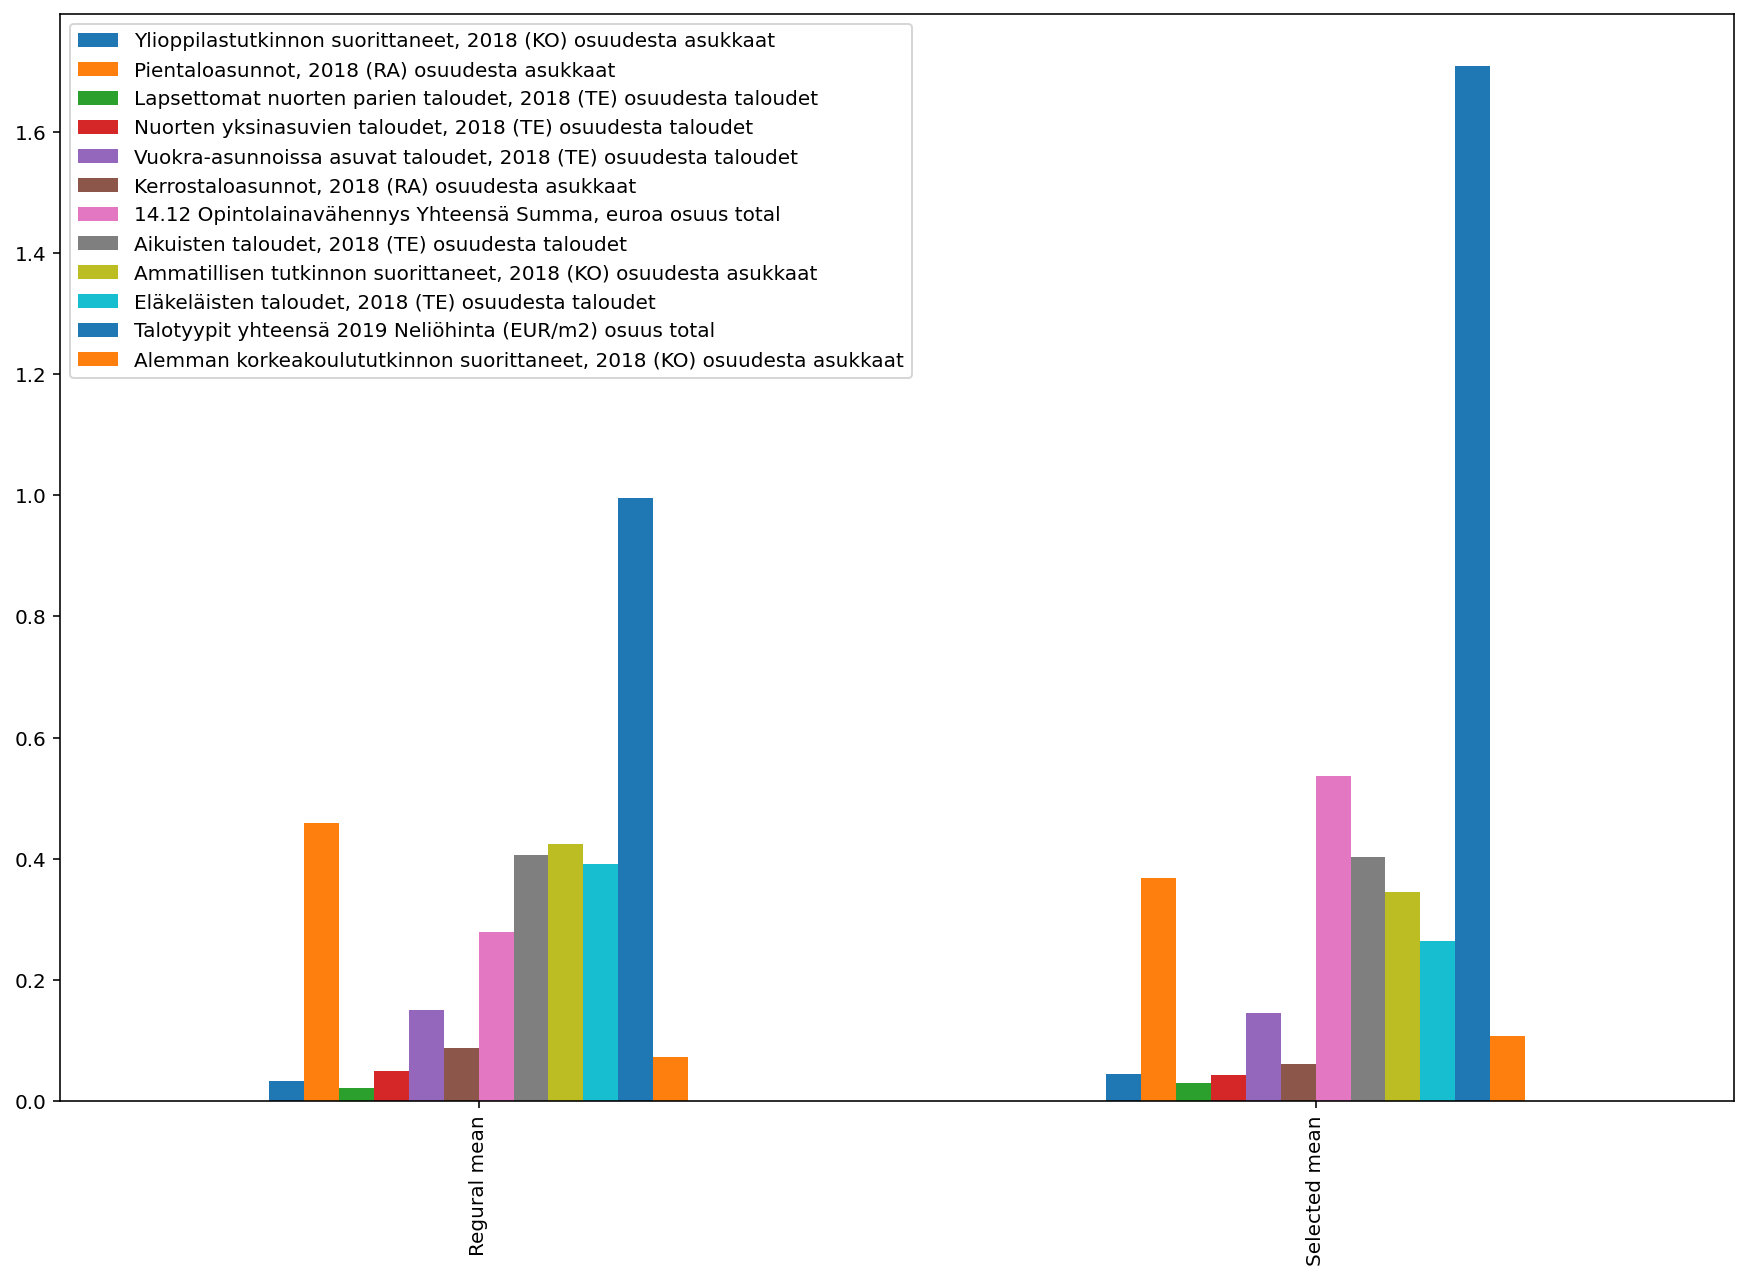

In [51]:
stats_data, k = plot_difference(data, compare_to, X, included_columns, shap_values, shap_index, col_num=columns, scaled=scaled)

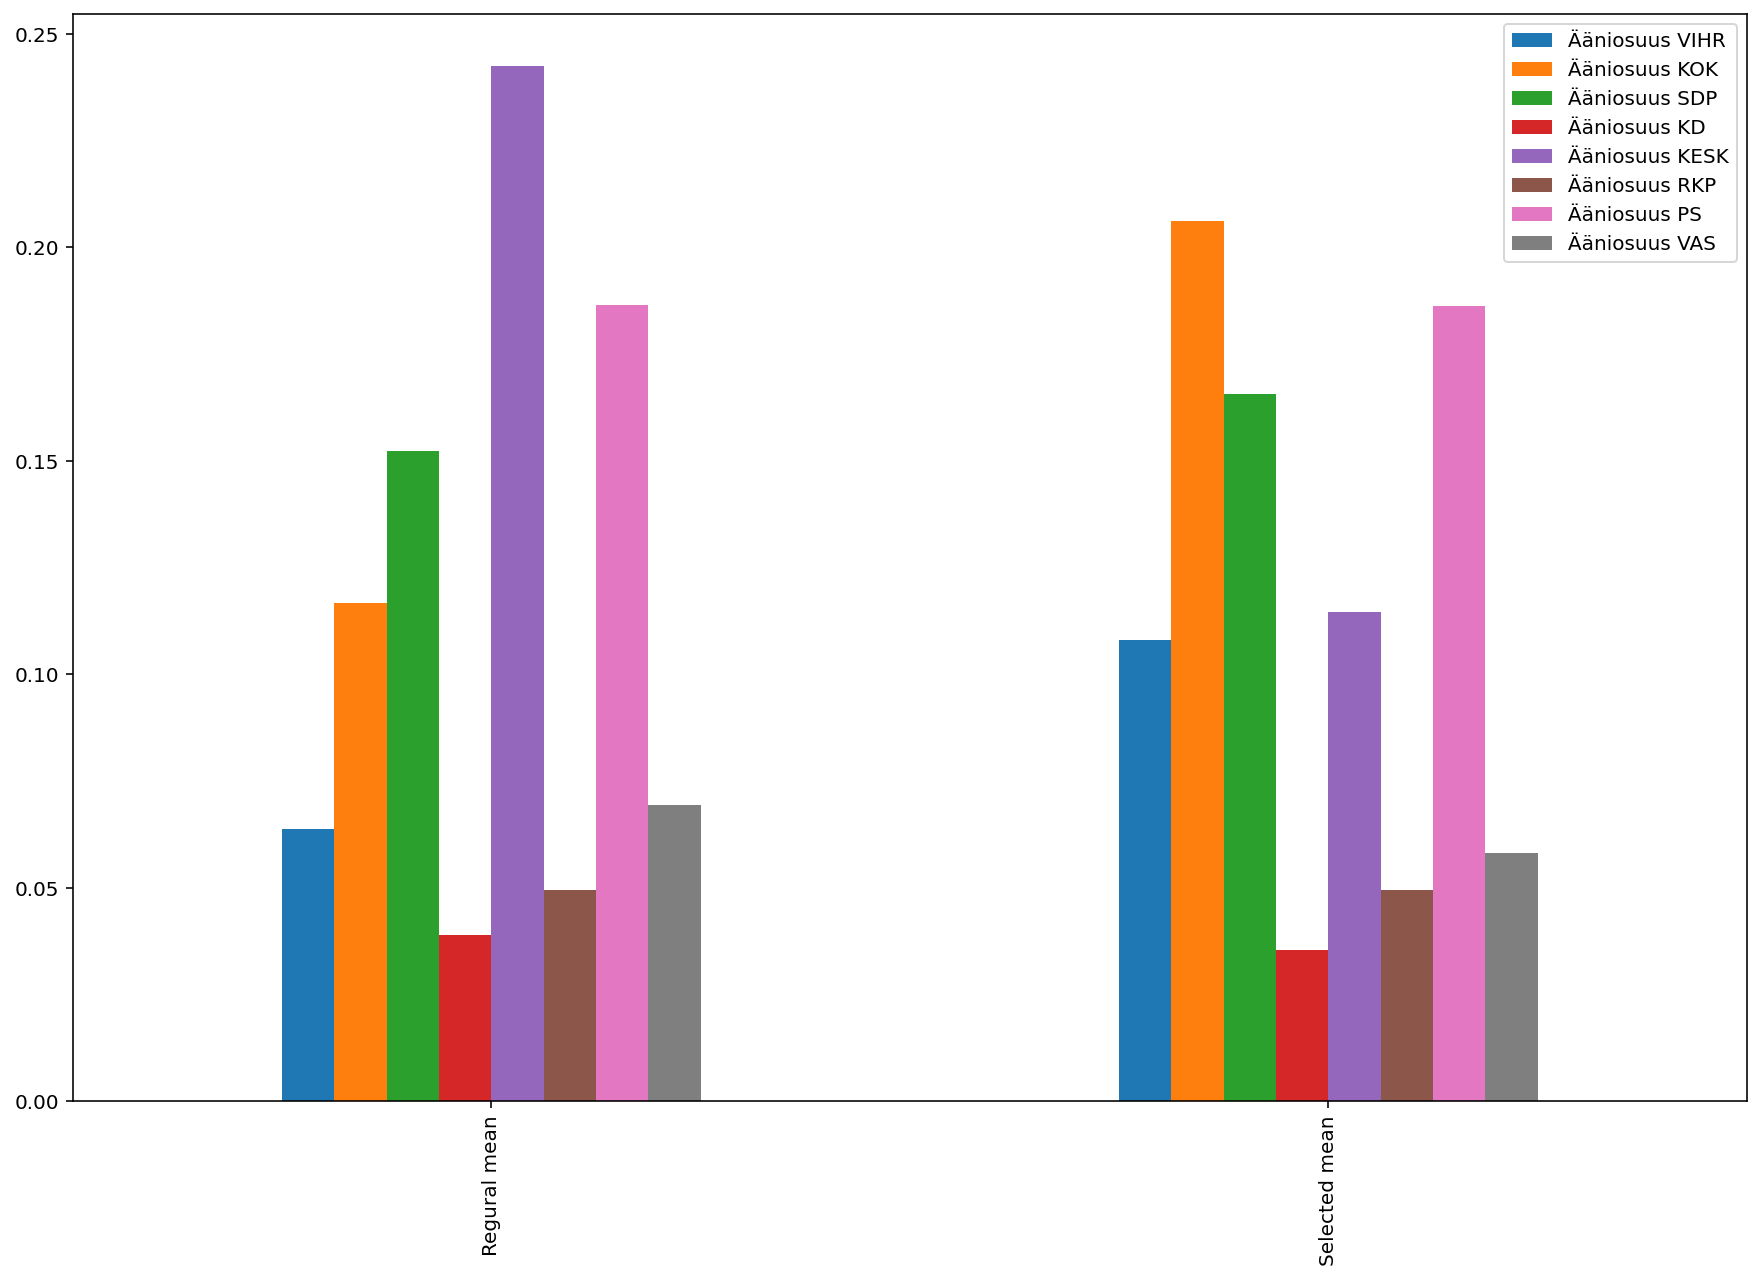

In [52]:
included_columns = all_included_columns
stats_data, k = plot_difference(data, compare_to, X, included_columns, shap_values, shap_index, col_num=0, scaled=False)

In [25]:
new = ['Postinumero','postcode_name', 'muncipality_name','Asukkaat yhteensä, 2018 (HE)', 'Suurin_puolue']
new_df, k2, col_list = create_example_df(compare_to, X, new, shap_index, shap_values, col_num=columns)
new_df.sample(5)

Postinumero postcode_name muncipality_name  Asukkaat yhteensä, 2018 (HE)  \
1700       60560    HALKOSAARI        Seinäjoki                         699.0   
1418       48800         KOTKA            Kotka                        2215.0   
2603       90540          OULU             Oulu                       11937.0   
471        15540      VILLÄHDE            Lahti                        4463.0   
1116       36270     KANGASALA        Kangasala                        1402.0   

     Suurin_puolue  Talotyypit yhteensä 2019 Neliöhinta (EUR/m2) osuus total  \
1700          KESK                                                  1.422046   
1418           SDP                                                  1.097238   
2603           KOK                                                  1.476181   
471             PS                                                  1.350944   
1116           KOK                                                  1.480221   

      Ammatillisen tutkinnon suorittaneet, 2018 (KO) osuudesta asukkaat  \
1700                                                           0.380544   
1418                                                           0.438826   
2603                                                           0.224596   
471                                                            0.402420   
1116                                                           0.361626   

      Ylioppilastutkinnon suorittaneet, 2018 (KO) osuudesta asukkaat  \
1700                                                        0.032904   
1418                                                        0.024379   
2603                                                        0.040379   
471                                                         0.025991   
1116                                                        0.034237   

      Alemman korkeakoulututkinnon suorittaneet, 2018 (KO) osuudesta asukkaat  \
1700                                                                 0.124464   
1418                                                                 0.120090   
2603                                                                 0.130937   
471                                                                  0.100829   
1116                                                                 0.097004   

      Kerrostaloasunnot, 2018 (RA) osuudesta asukkaat  \
1700                                         0.000000   
1418                                         0.000000   
2603                                         0.047667   
471                                          0.027784   
1116                                         0.081312   

      Pientaloasunnot, 2018 (RA) osuudesta asukkaat  \
1700                                       0.370529   
1418                                       0.433860   
2603                                       0.307783   
471                                        0.395698   
1116                                       0.378031   

      Nuorten yksinasuvien taloudet, 2018 (TE) osuudesta taloudet  \
1700                                                     0.040323   
1418                                                     0.029095   
2603                                                     0.067249   
471                                                      0.025684   
1116                                                     0.036585   

      Lapsettomat nuorten parien taloudet, 2018 (TE) osuudesta taloudet  \
1700                                                           0.060484   
1418                                                           0.035560   
2603                                                           0.061423   
471                                                            0.029034   
1116                                                           0.022648   

      Aikuisten taloudet, 2018 (TE) osuudesta taloudet  \
1700                                          0.439516   
1418      

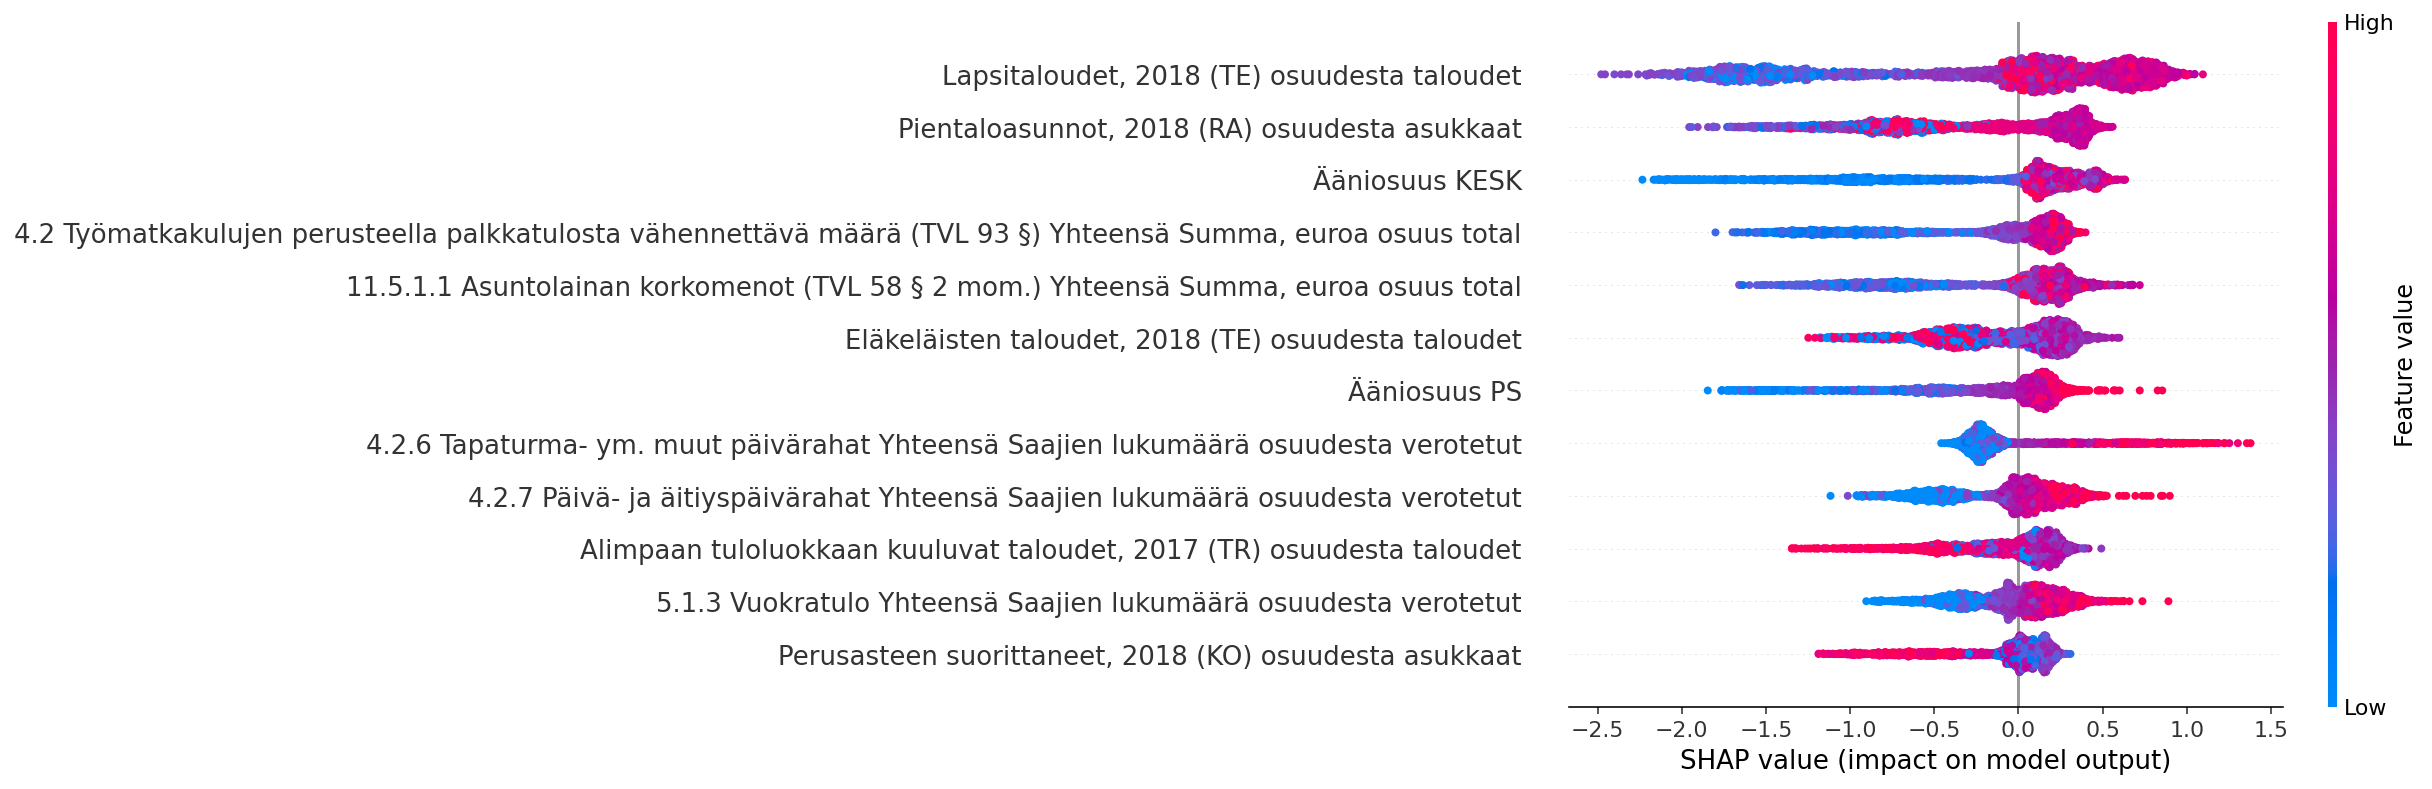

In [53]:
shap_index = 3
included_columns = []
columns = 12
scaled = False

compare_to = data[(data['cluster']) == shap_index].copy()
compare_to = create_share_of_values(compare_to)
compare_to = create_new_values(compare_to, vaalidata)

shap.summary_plot(shap_values[shap_index], X,  max_display=columns)

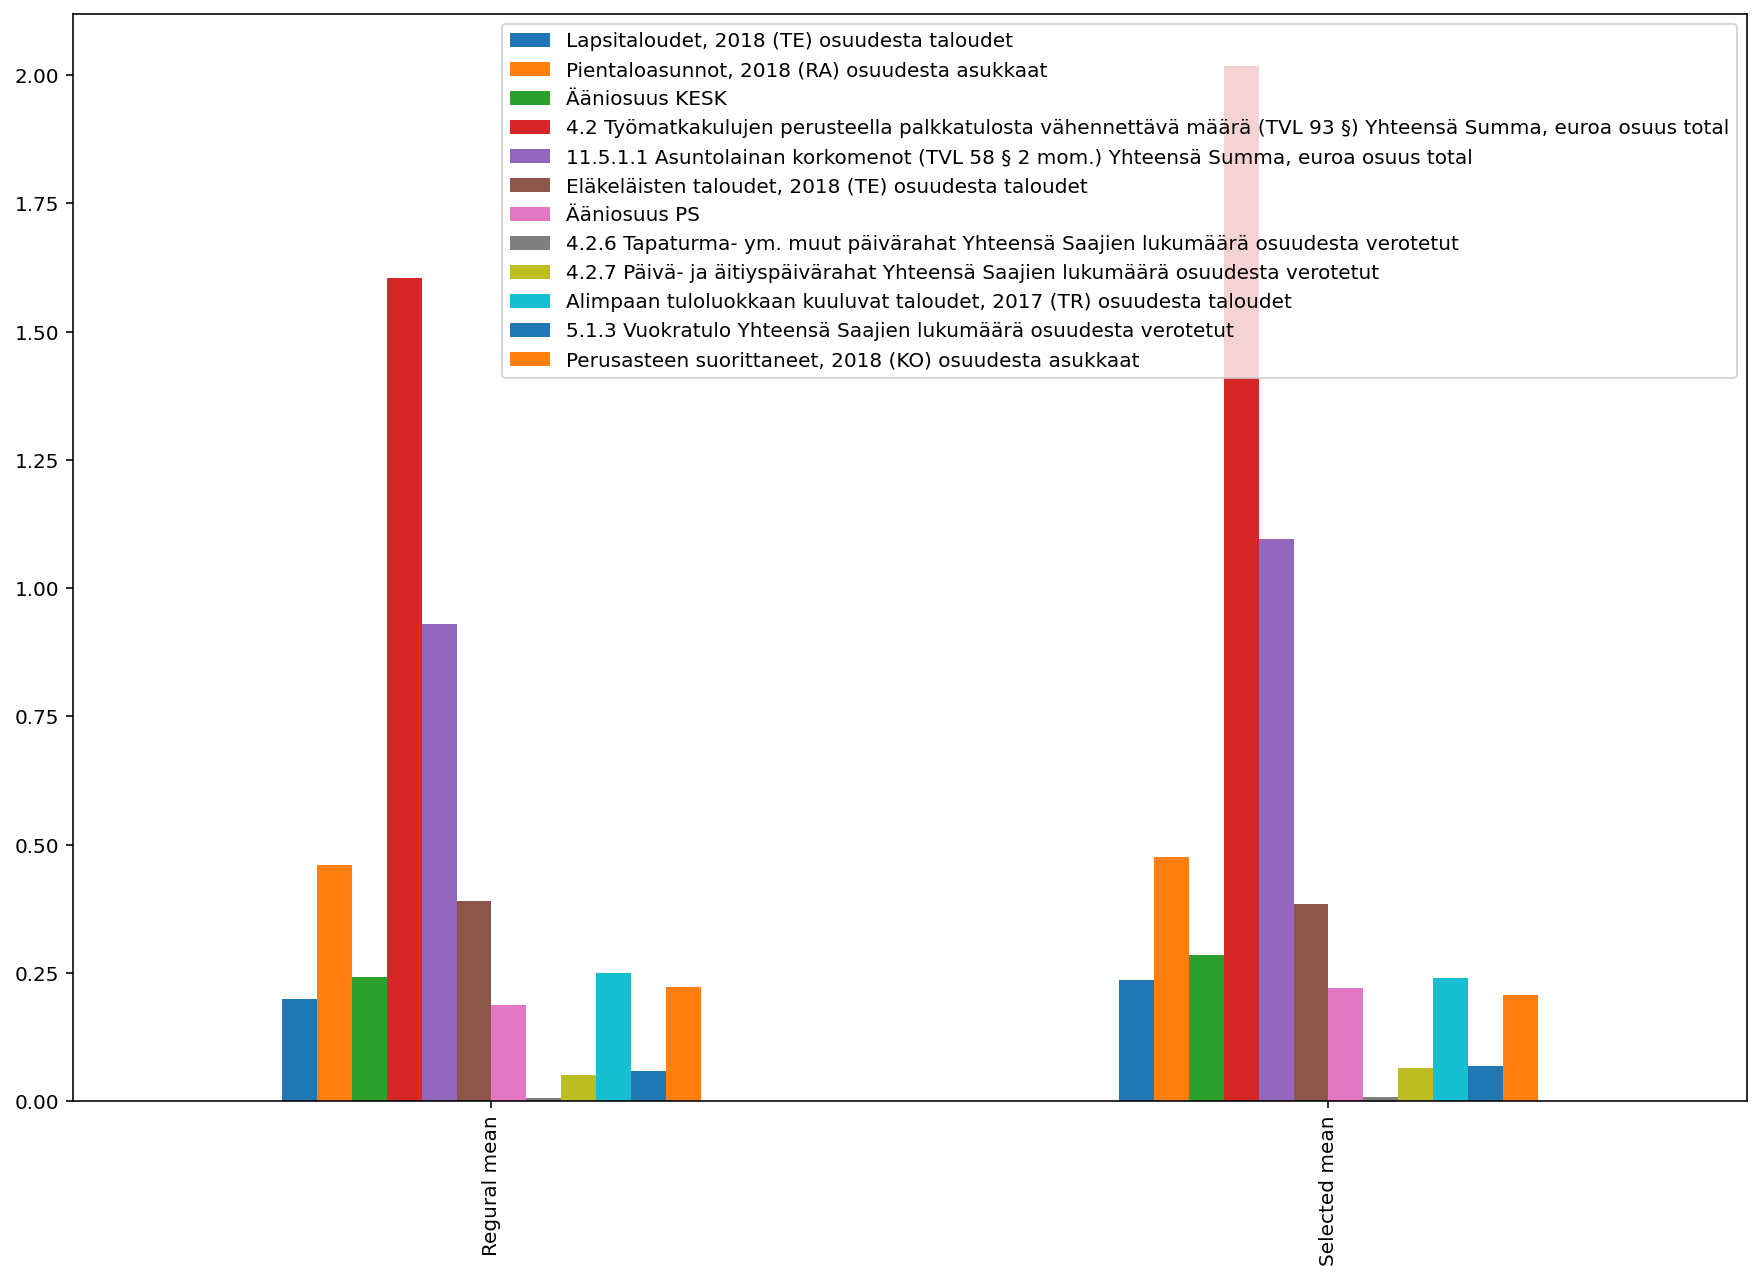

In [54]:
stats_data, k = plot_difference(data, compare_to, X, included_columns, shap_values, shap_index, col_num=columns, scaled=scaled)

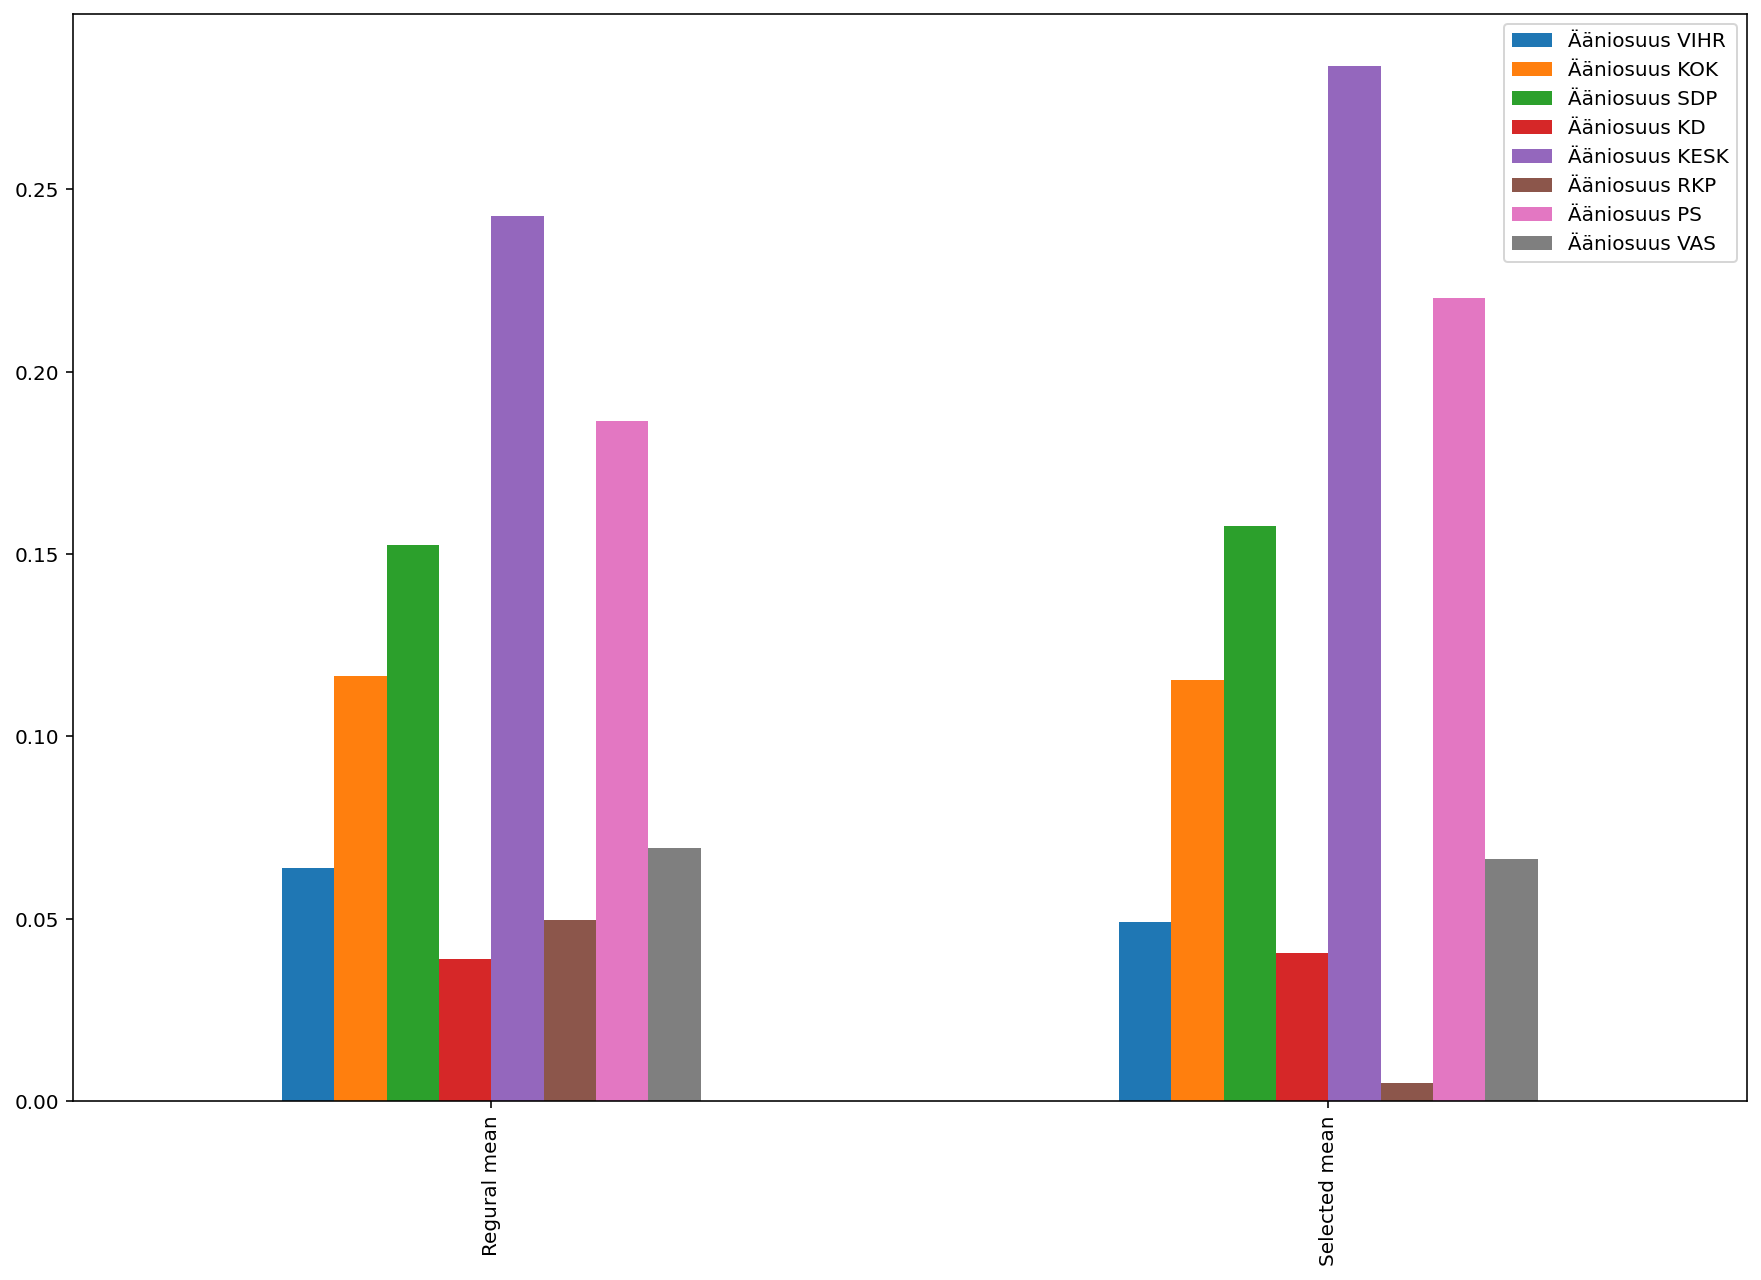

In [55]:
included_columns = all_included_columns
stats_data, k = plot_difference(data, compare_to, X, included_columns, shap_values, shap_index, col_num=0, scaled=False)

In [29]:
new = ['Postinumero','postcode_name', 'muncipality_name','Asukkaat yhteensä, 2018 (HE)', 'Suurin_puolue']
new_df, k2, col_list = create_example_df(compare_to, X, new, shap_index, shap_values, col_num=columns)
new_df.sample(5)

Postinumero postcode_name muncipality_name  Asukkaat yhteensä, 2018 (HE)  \
1791       62130     HELLANMAA            Lapua                         523.0   
1259       41440     RUUHIMÄKI         Toivakka                         229.0   
2738       95230     MAKSNIEMI             Simo                         768.0   
1158       38720   VIHTELJÄRVI       Kankaanpää                         404.0   
2616       90840    HAUKIPUDAS             Oulu                        1929.0   

     Suurin_puolue  Perusasteen suorittaneet, 2018 (KO) osuudesta asukkaat  \
1791           KOK                                                0.212237   
1259          KESK                                                0.161572   
2738          KESK                                                0.195312   
1158            PS                                                0.267327   
2616          KESK                                                0.124417   

      Pientaloasunnot, 2018 (RA) osuudesta asukkaat  \
1791                                       0.460803   
1259                                       0.484716   
2738                                       0.476562   
1158                                       0.586634   
2616                                       0.355106   

      Lapsitaloudet, 2018 (TE) osuudesta taloudet  \
1791                                     0.286408   
1259                                     0.219048   
2738                                     0.221239   
1158                                     0.192513   
2616                                     0.370597   

      Eläkeläisten taloudet, 2018 (TE) osuudesta taloudet  \
1791                                             0.446602   
1259                                             0.361905   
2738                                             0.448378   
1158                                             0.459893   
2616                                             0.263400   

      Alimpaan tuloluokkaan kuuluvat taloudet, 2017 (TR) osuudesta taloudet  \
1791                                                               0.266990   
1259                                                               0.257143   
2738                                                               0.159292   
1158                                                               0.342246   
2616                                                               0.229709   

      4.2.6 Tapaturma- ym. muut päivärahat Yhteensä Saajien lukumäärä osuudesta verotetut  \
1791                                                                             0.000000   
1259                                                                             0.000000   
2738                                                                             0.000000   
1158                                                                             0.022535   
2616                                                                             0.007746   

      4.2.7 Päivä- ja äitiyspäivärahat Yhteensä Saajien lukumäärä osuudesta verotetut  \
1791                                                                         0.053571   
1259                                                                         0.074713   
2738                                                                         0.060465   
1158                                                                         0.067606   
2616                                                                         0.092958   

      5.1.3 Vuokratulo Yhteensä Saajien lukumäärä osuudesta verotetut  \
1791                                                         0.073661   
1259                                                         0.000000   
2738                                                         0.057364   
1158                                                         0.095775   
2616                                                         0.082394   

      11.5.1.1 Asuntolai

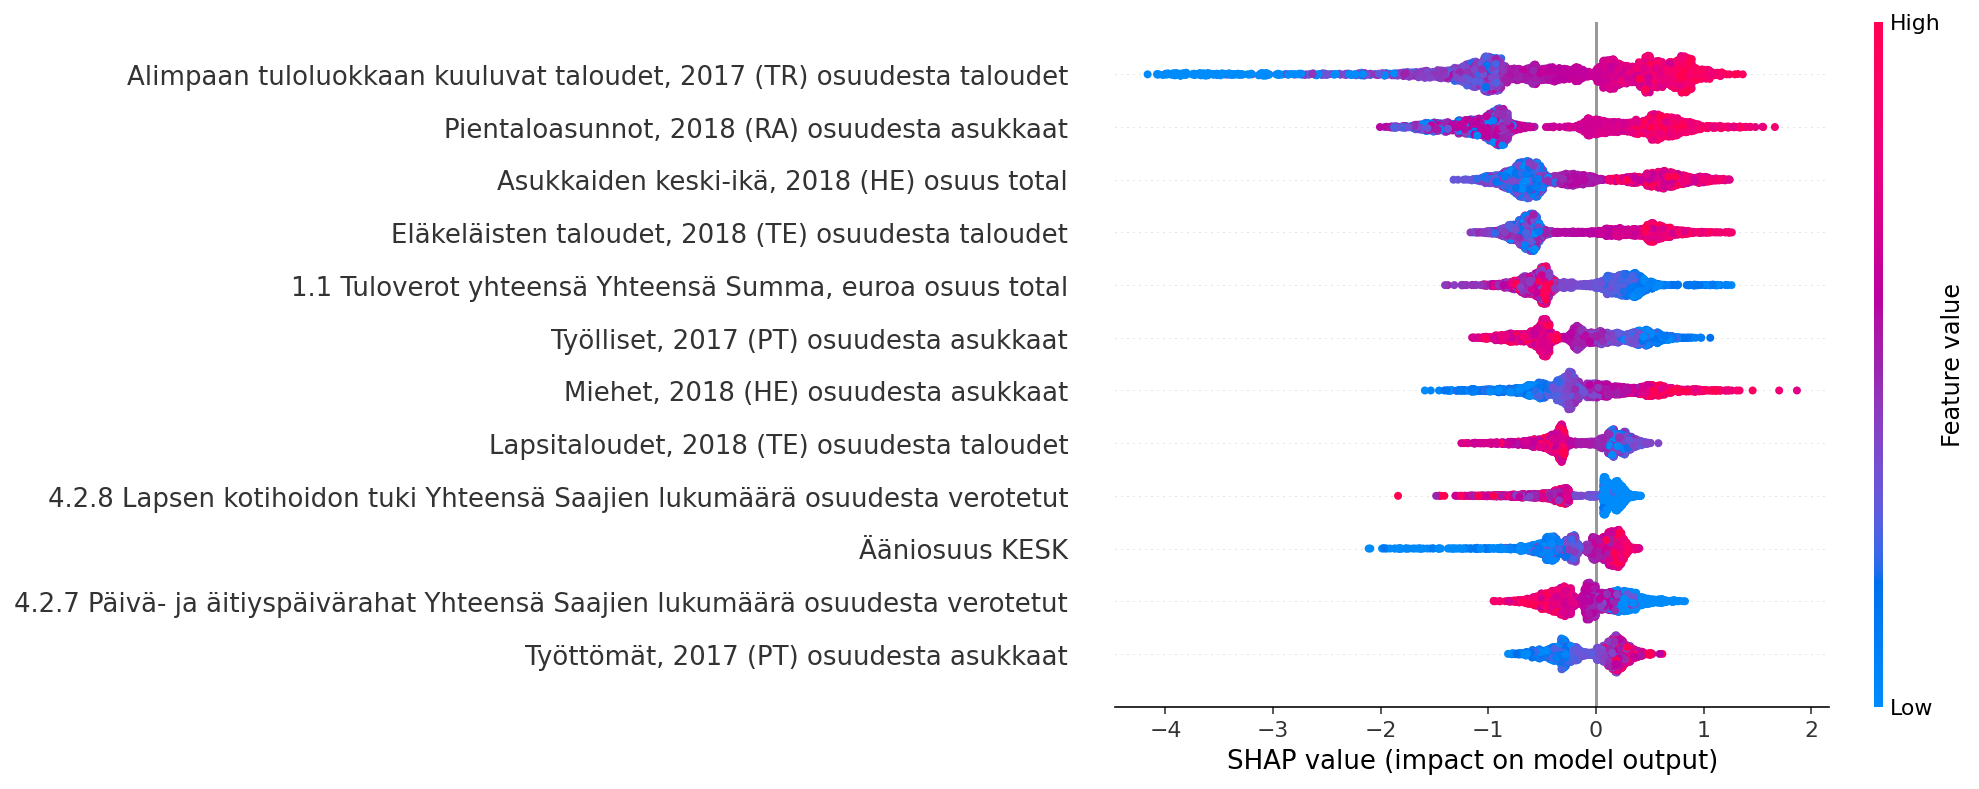

In [56]:
shap_index = 4
included_columns = []
columns = 12
scaled = False

compare_to = data[(data['cluster']) == shap_index].copy()
compare_to = create_share_of_values(compare_to)
compare_to = create_new_values(compare_to, vaalidata)

shap.summary_plot(shap_values[shap_index], X,  max_display=columns)

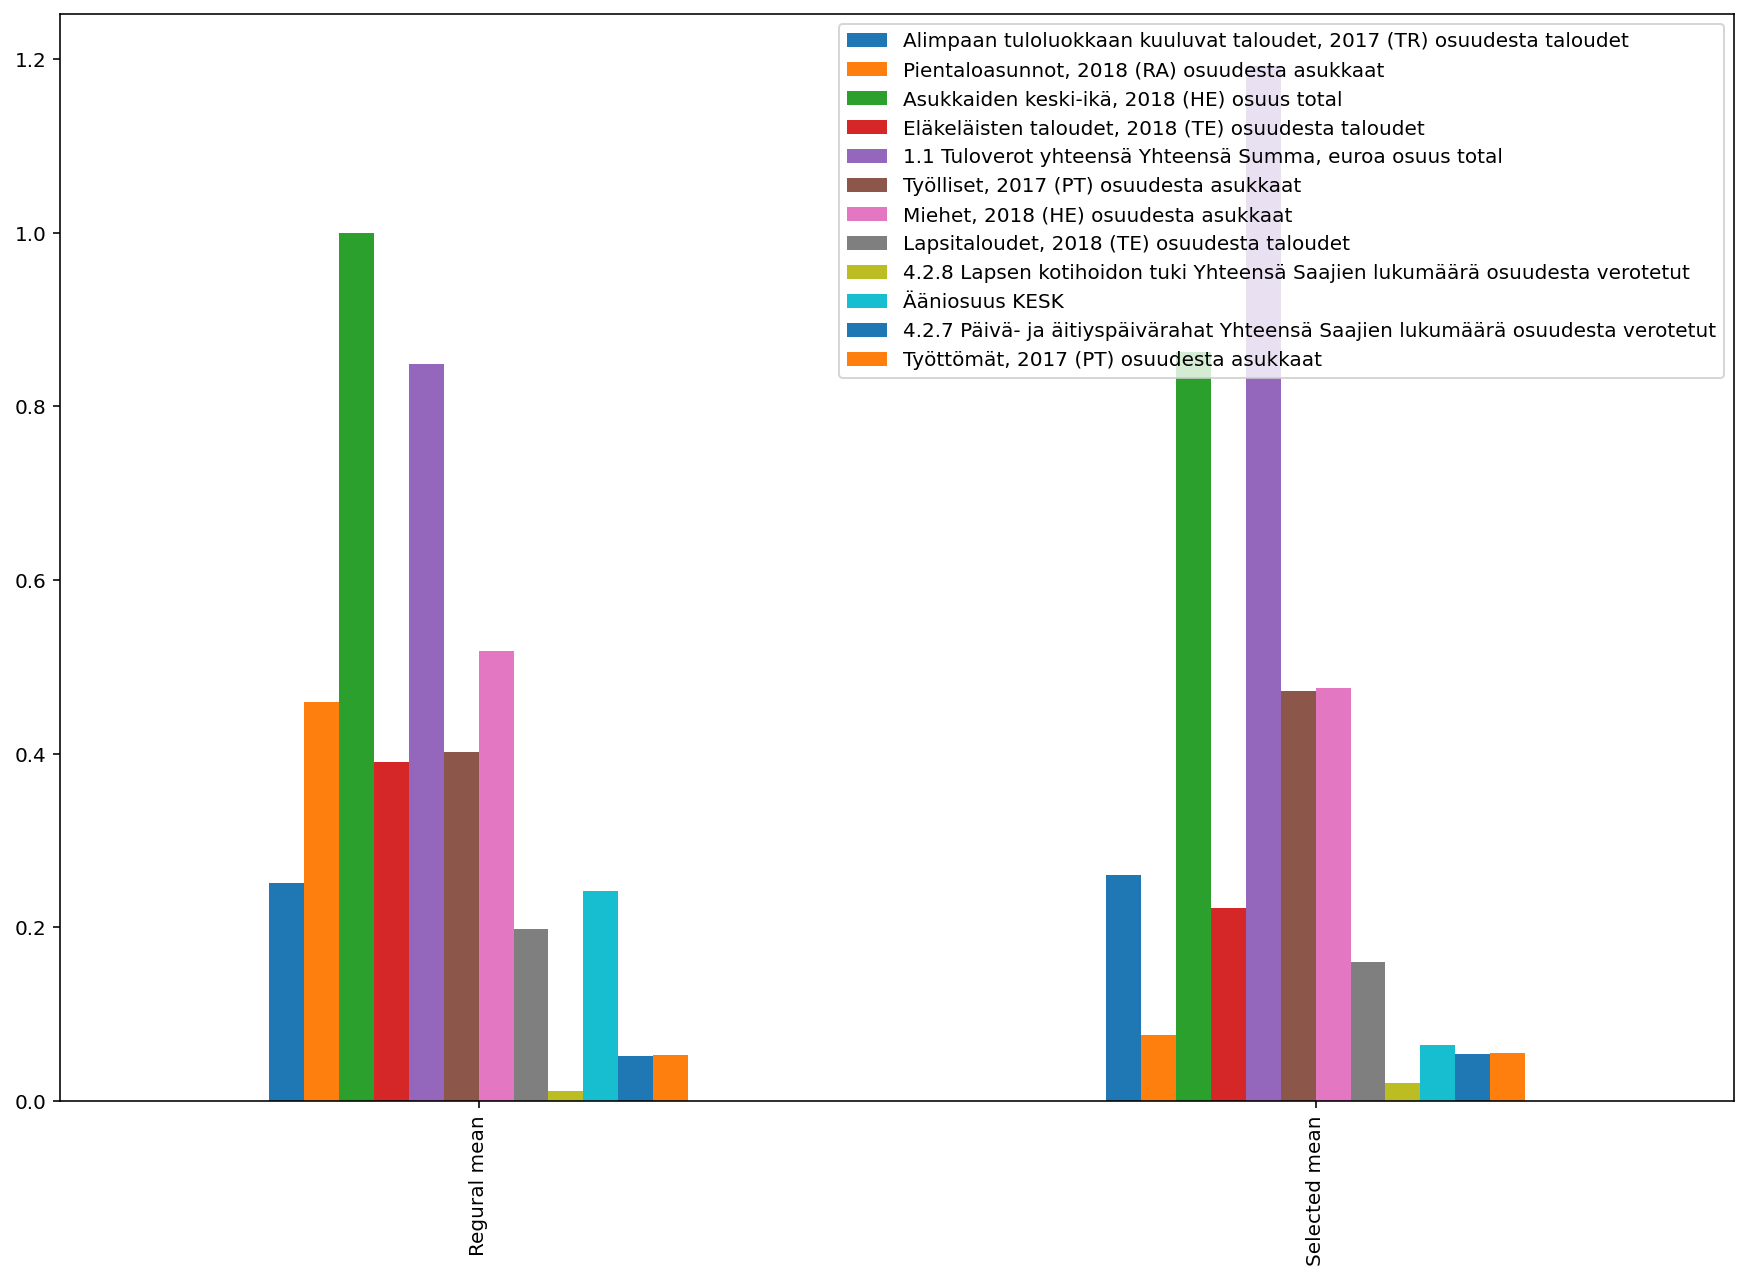

In [57]:
stats_data, k = plot_difference(data, compare_to, X, included_columns, shap_values, shap_index, col_num=columns, scaled=scaled)

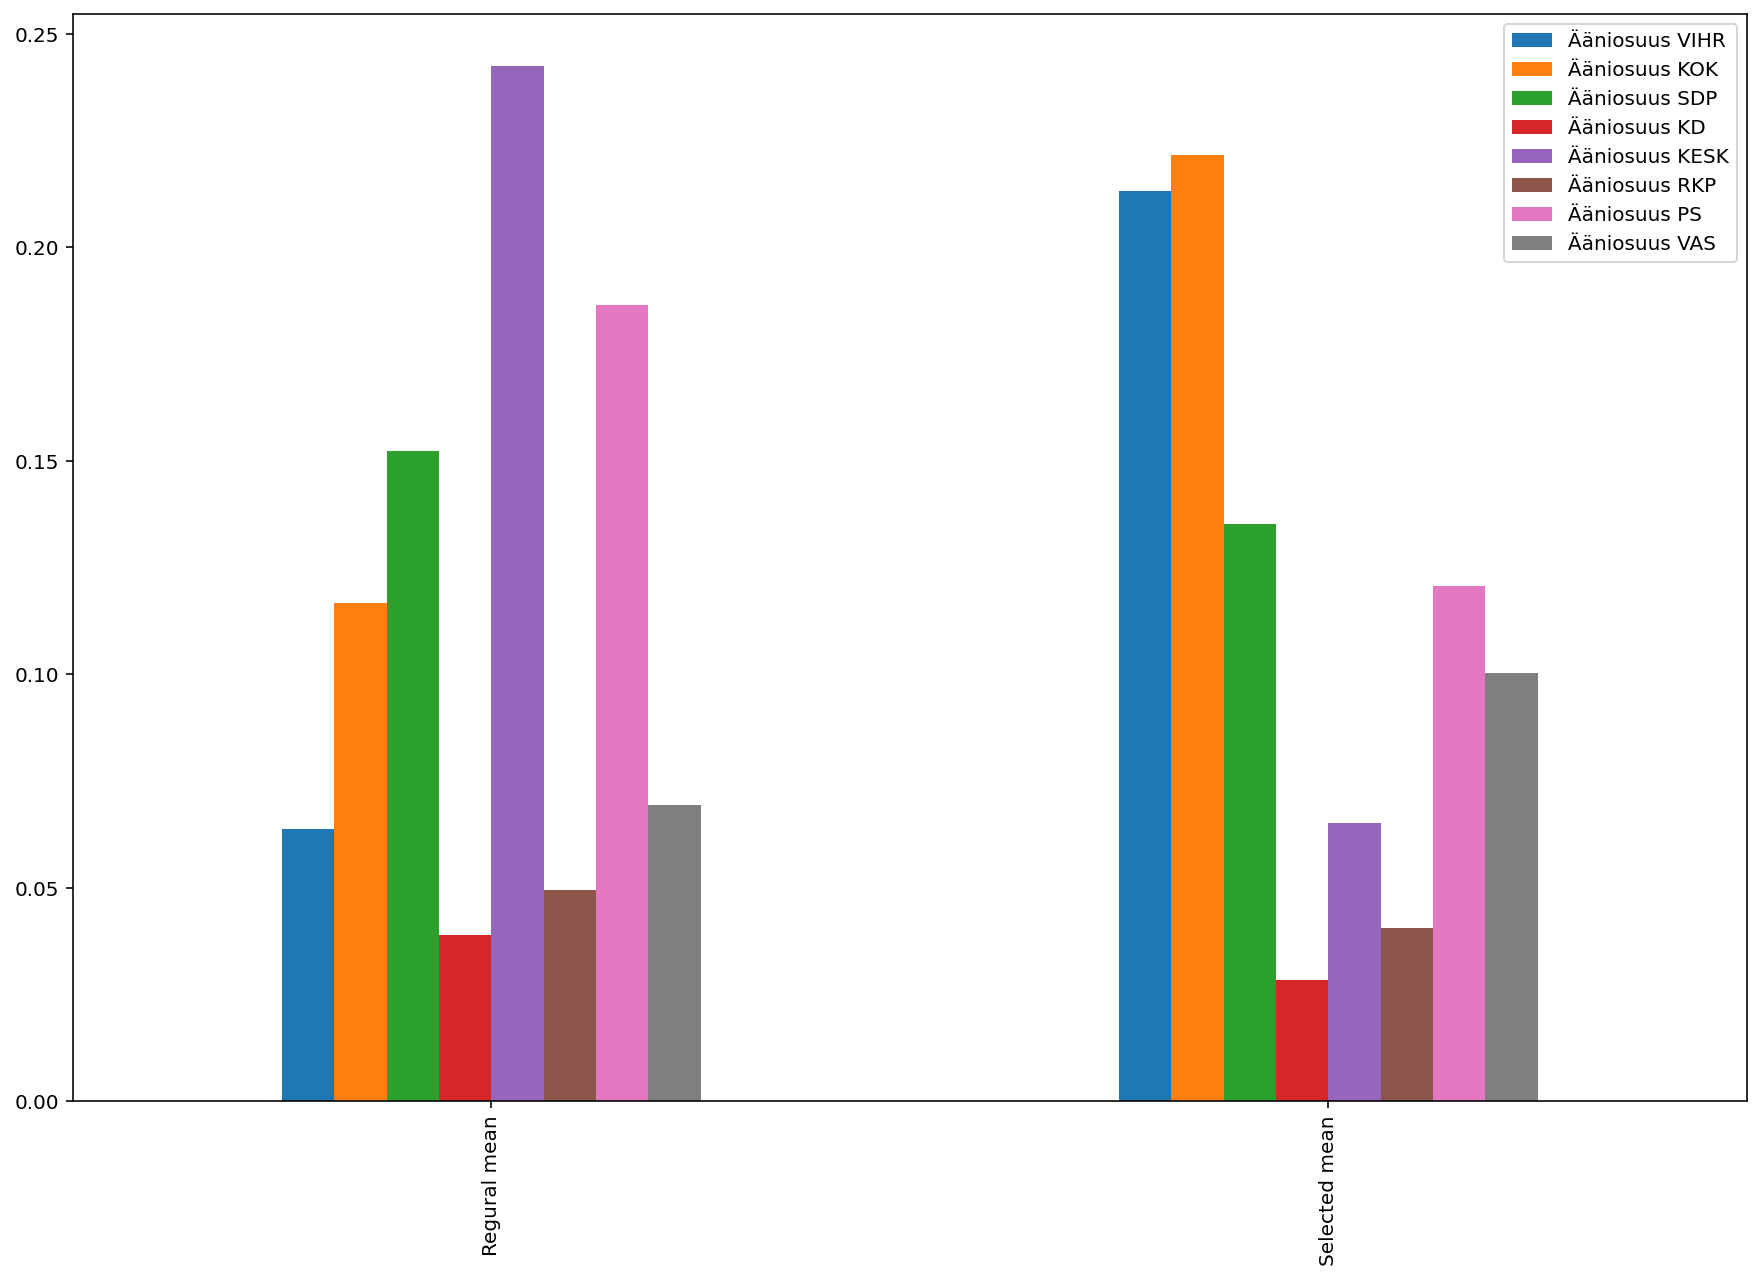

In [58]:
included_columns = all_included_columns
stats_data, k = plot_difference(data, compare_to, X, included_columns, shap_values, shap_index, col_num=0, scaled=False)

In [33]:
new = ['Postinumero','postcode_name', 'muncipality_name','Asukkaat yhteensä, 2018 (HE)', 'Suurin_puolue']
new_df, k2, col_list = create_example_df(compare_to, X, new, shap_index, shap_values, col_num=columns)
new_df.sample(5)

Postinumero postcode_name muncipality_name  Asukkaat yhteensä, 2018 (HE)  \
44         00620      HELSINKI         Helsinki                        3285.0   
2585       90120          OULU             Oulu                        6817.0   
19         00320      HELSINKI         Helsinki                       10199.0   
1016       33900       TAMPERE          Tampere                       12077.0   
2310       80100       JOENSUU          Joensuu                        9640.0   

     Suurin_puolue  Miehet, 2018 (HE) osuudesta asukkaat  \
44            VIHR                              0.464231   
2585           KOK                              0.471322   
19            VIHR                              0.448181   
1016           SDP                              0.472054   
2310          VIHR                              0.445332   

      Asukkaiden keski-ikä, 2018 (HE) osuus total  \
44                                       0.957018   
2585                                     0.891767   
19                                       0.870016   
1016                                     0.848266   
2310                                     0.935267   

      Pientaloasunnot, 2018 (RA) osuudesta asukkaat  \
44                                         0.162253   
2585                                       0.009975   
19                                         0.016864   
1016                                       0.063509   
2310                                       0.114315   

      Työlliset, 2017 (PT) osuudesta asukkaat  \
44                                   0.471537   
2585                                 0.476456   
19                                   0.566722   
1016                                 0.440921   
2310                                 0.373755   

      Työttömät, 2017 (PT) osuudesta asukkaat  \
44                                   0.032268   
2585                                 0.089629   
19                                   0.046573   
1016                                 0.079407   
2310                                 0.070747   

      Lapsitaloudet, 2018 (TE) osuudesta taloudet  \
44                                       0.213498   
2585                                     0.070876   
19                                       0.123016   
1016                                     0.143137   
2310                                     0.079473   

      Eläkeläisten taloudet, 2018 (TE) osuudesta taloudet  \
44                                               0.275795   
2585                                             0.222938   
19                                               0.186508   
1016                                             0.193648   
2310                                             0.305996   

      Alimpaan tuloluokkaan kuuluvat taloudet, 2017 (TR) osuudesta taloudet  \
44                                                                 0.168073   
2585                                                               0.351589   
19                                                                 0.218730   
1016                                                               0.277179   
2310                                                               0.413071   

      4.2.7 Päivä- ja äitiyspäivärahat Yhteensä Saajien lukumäärä osuudesta verotetut  \
44                                                                           0.046772   
2585                                                                         0.053577   
19                                                                           0.049679   
1016                                                                         0.069985   
2310                                                                         0.035022   

      4.2.8 Lapsen kotihoidon tuki Yhteensä Saajien lukumäärä osuudesta verotetut  \
44                                                                       0.023715   
2585                                               

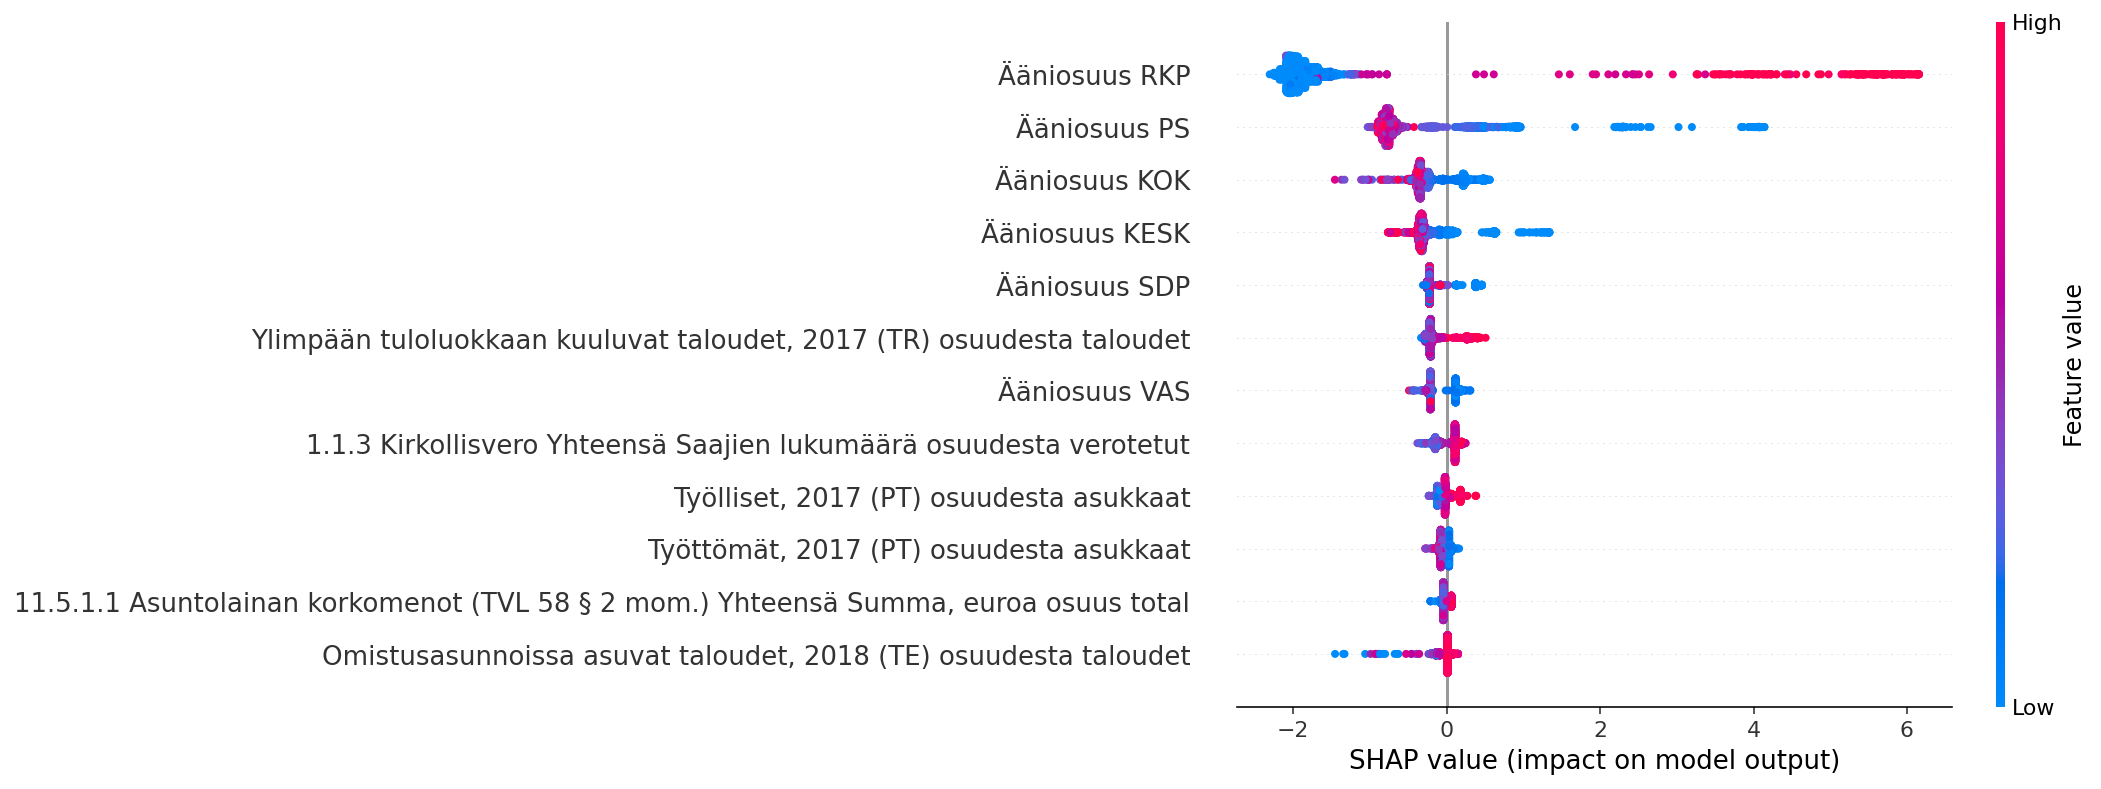

In [59]:
shap_index = 5
included_columns = []
columns = 12
scaled = False

compare_to = data[(data['cluster']) == shap_index].copy()
compare_to = create_share_of_values(compare_to)
compare_to = create_new_values(compare_to, vaalidata)

shap.summary_plot(shap_values[shap_index], X,  max_display=columns)

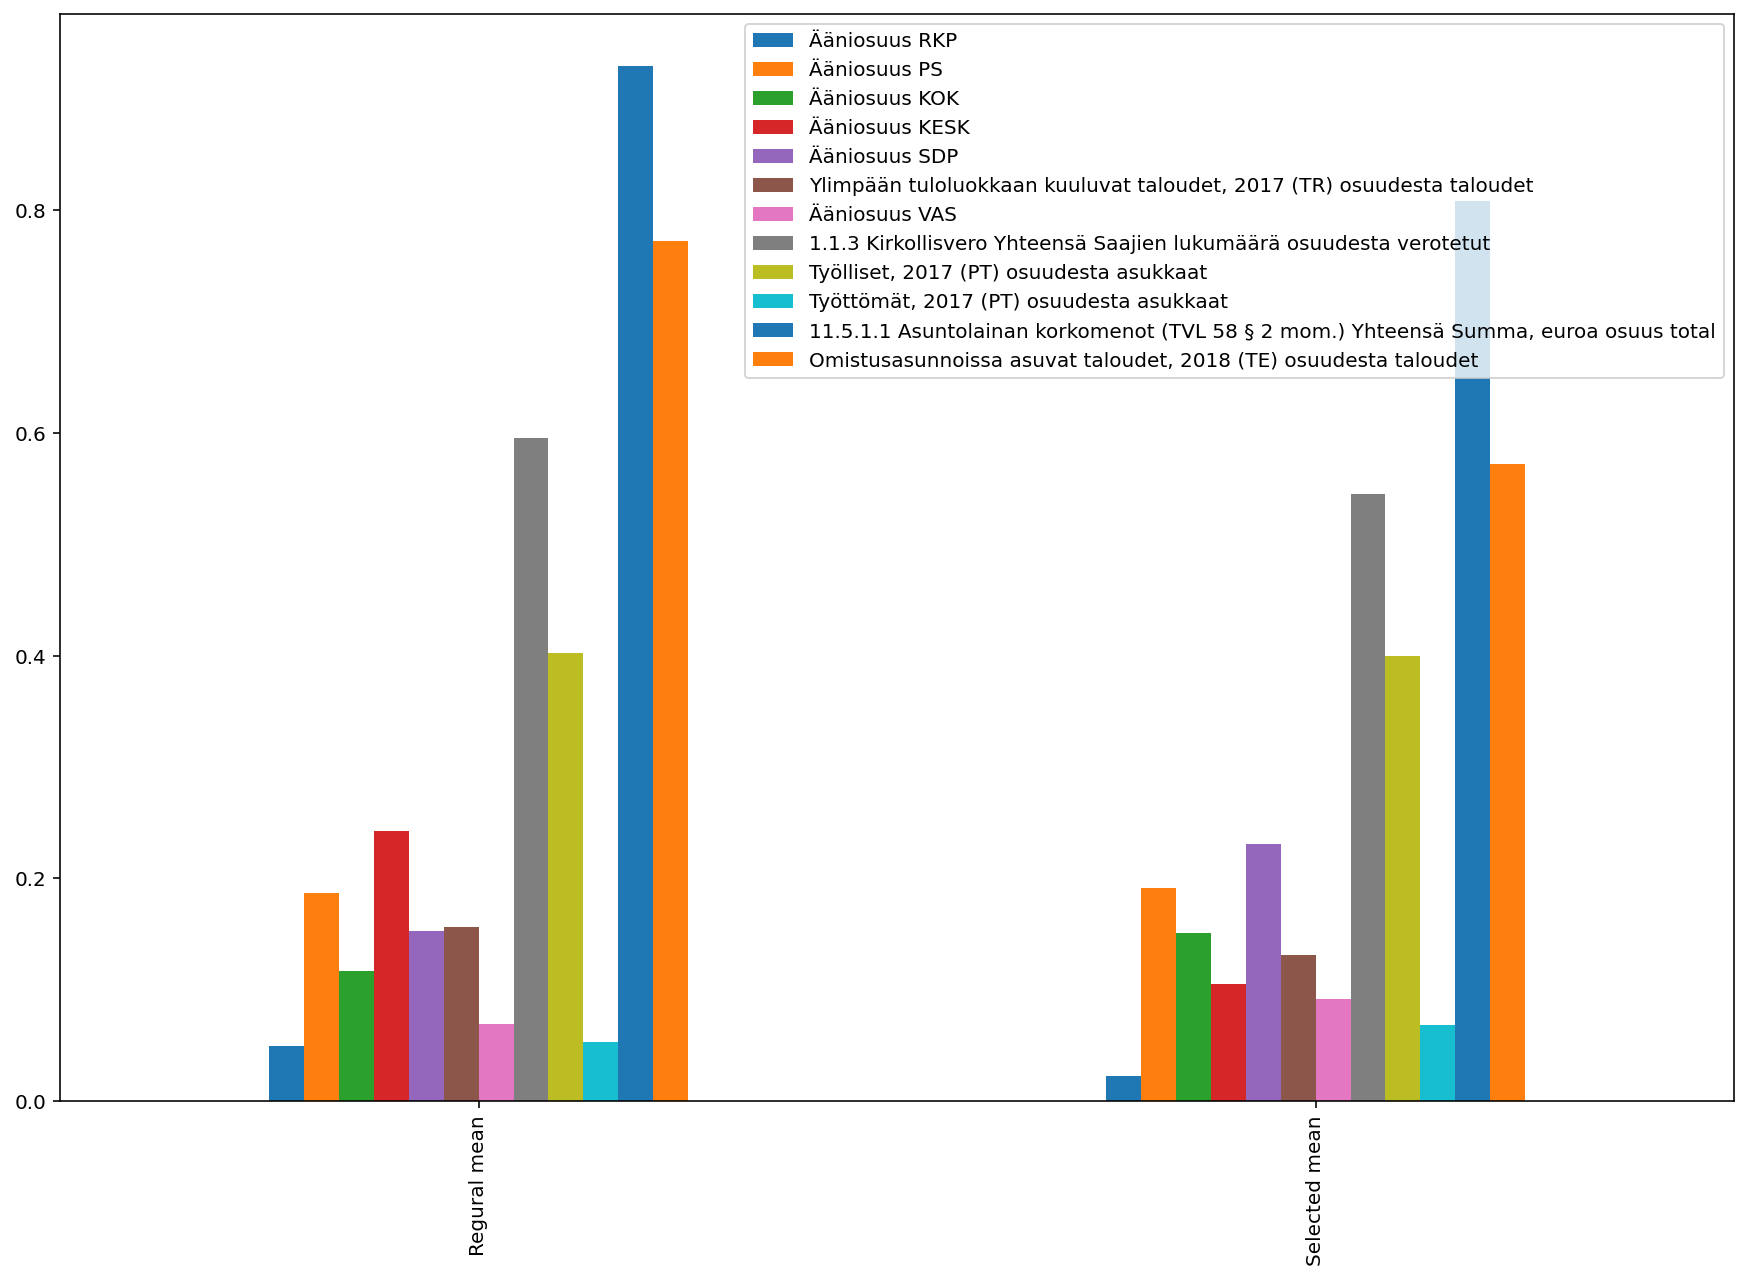

In [60]:
stats_data, k = plot_difference(data, compare_to, X, included_columns, shap_values, shap_index, col_num=columns, scaled=scaled)

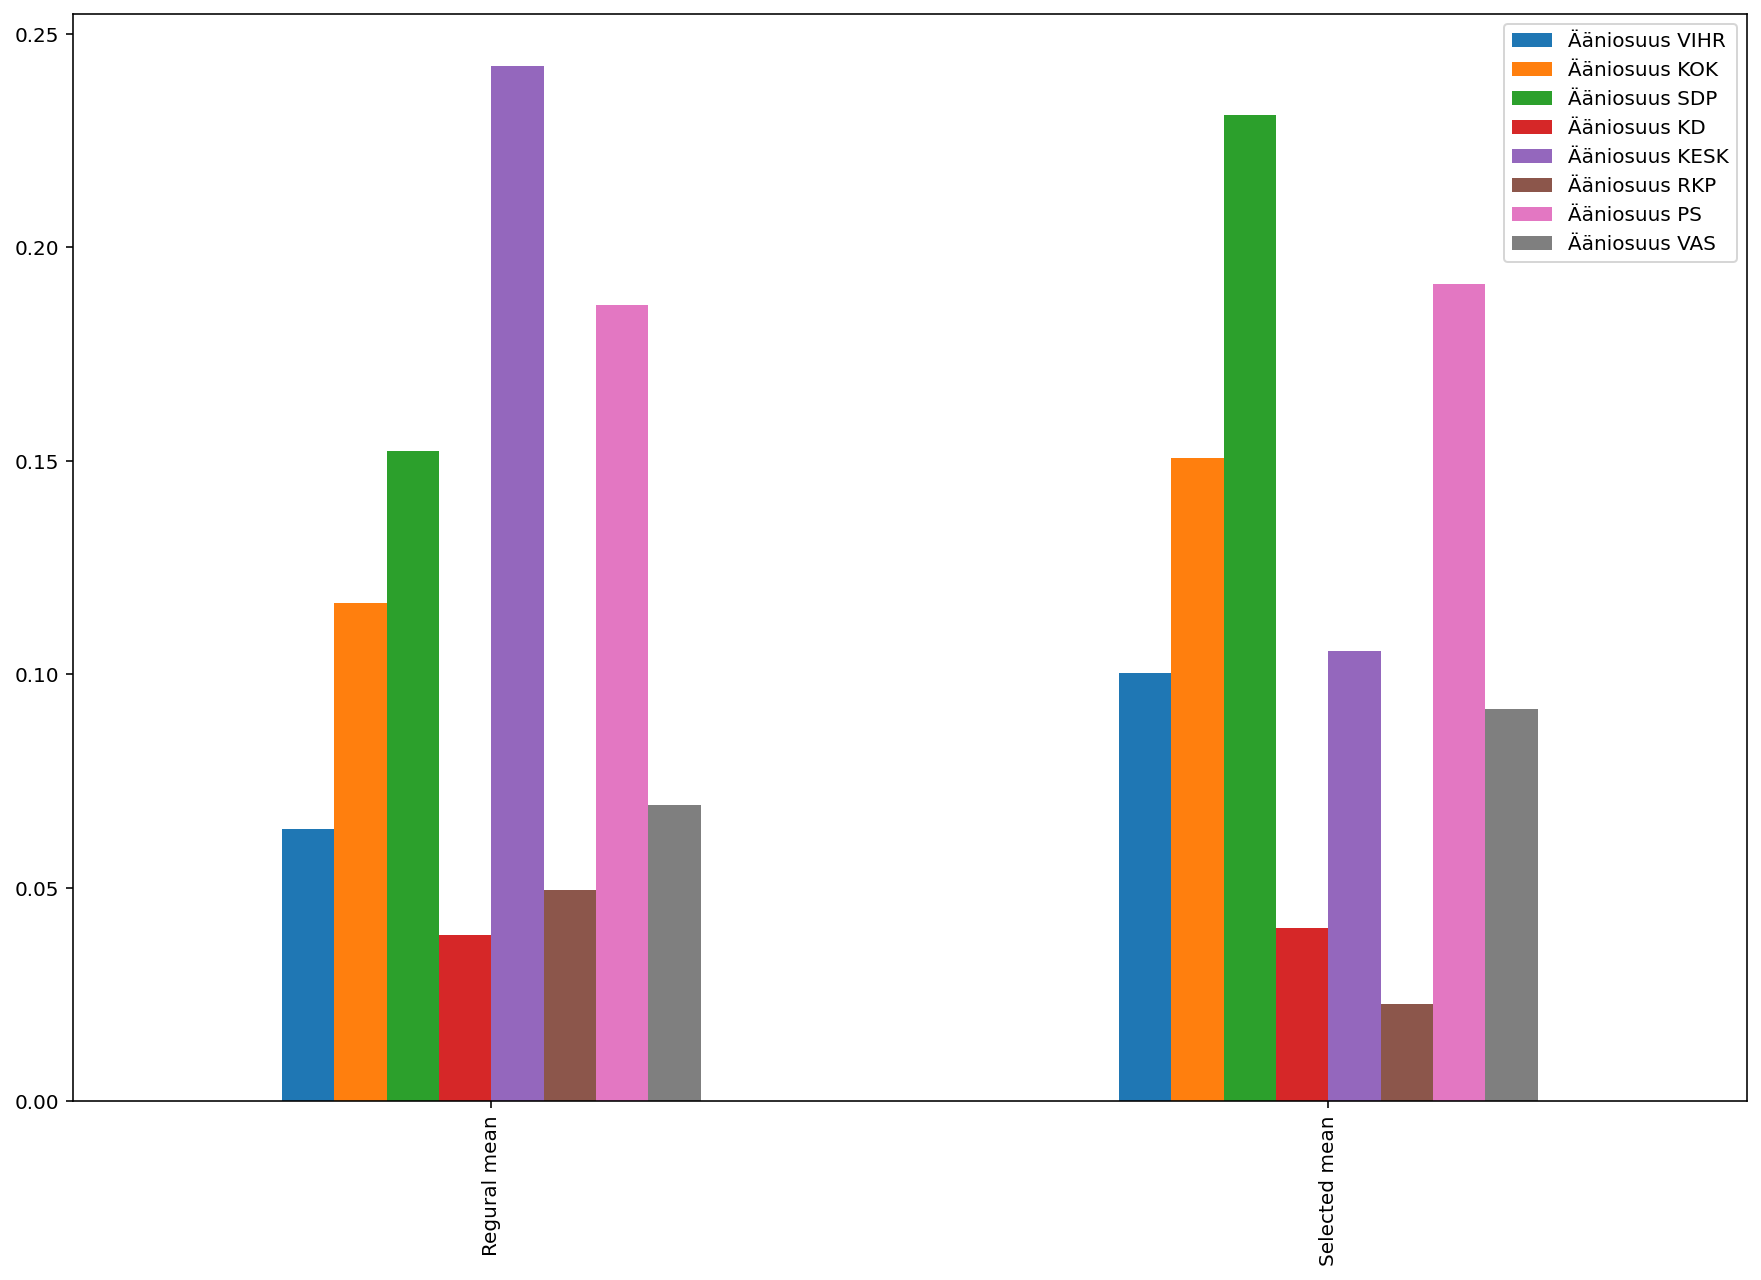

In [61]:
included_columns = all_included_columns
stats_data, k = plot_difference(data, compare_to, X, included_columns, shap_values, shap_index, col_num=0, scaled=False)

In [37]:
new = ['Postinumero','postcode_name', 'muncipality_name','Asukkaat yhteensä, 2018 (HE)', 'Suurin_puolue']
new_df, k2, col_list = create_example_df(compare_to, X, new, shap_index, shap_values, col_num=columns)
new_df.sample(5)

Postinumero postcode_name muncipality_name  Asukkaat yhteensä, 2018 (HE)  \
838        28100          PORI             Pori                       12643.0   
2607       90580          OULU             Oulu                        4373.0   
361        10410    ÅMINNEFORS        Raasepori                         343.0   
847        28360          PORI             Pori                        4068.0   
2640       91430    LEPPINIEMI            Muhos                         123.0   

     Suurin_puolue  Työlliset, 2017 (PT) osuudesta asukkaat  \
838            SDP                                 0.355849   
2607            PS                                 0.361994   
361            SDP                                 0.376093   
847            SDP                                 0.380039   
2640          KESK                                 0.479675   

      Työttömät, 2017 (PT) osuudesta asukkaat  \
838                                  0.067468   
2607                                 0.099703   
361                                  0.072886   
847                                  0.065634   
2640                                 0.097561   

      Omistusasunnoissa asuvat taloudet, 2018 (TE) osuudesta taloudet  \
838                                                          0.435287   
2607                                                         0.542022   
361                                                          0.721053   
847                                                          0.735011   
2640                                                         0.500000   

      Ylimpään tuloluokkaan kuuluvat taloudet, 2017 (TR) osuudesta taloudet  \
838                                                                0.113908   
2607                                                               0.128090   
361                                                                0.131579   
847                                                                0.117162   
2640                                                               0.134615   

      1.1.3 Kirkollisvero Yhteensä Saajien lukumäärä osuudesta verotetut  \
838                                                             0.578588   
2607                                                            0.513308   
361                                                             0.470948   
847                                                             0.592521   
2640                                                            0.500000   

      11.5.1.1 Asuntolainan korkomenot (TVL 58 § 2 mom.) Yhteensä Summa, euroa osuus total  \
838                                                                               0.506974   
2607                                                                              0.641715   
361                                                                               1.310314   
847                                                                               0.892118   
2640                                                                              1.247662   

      Ääniosuus KESK  Ääniosuus KOK  Ääniosuus PS  Ääniosuus RKP  \
838         0.076031       0.224227      0.185098       0.003280   
2607        0.120573       0.110625      0.244727       0.000796   
361         0.018248       0.062044      0.091241       0.237226   
847         0.071680       0.135278      0.232256       0.001405   
2640        0.309091       0.054545      0.254545       0.000000   

      Ääniosuus SDP  Ääniosuus VAS  
838        0.239105       0.114339  
2607       0.146836       0.179069  
361        0.317518       0.083942  
847        0.293043       0.147927  
2640       0.072727       0.145455

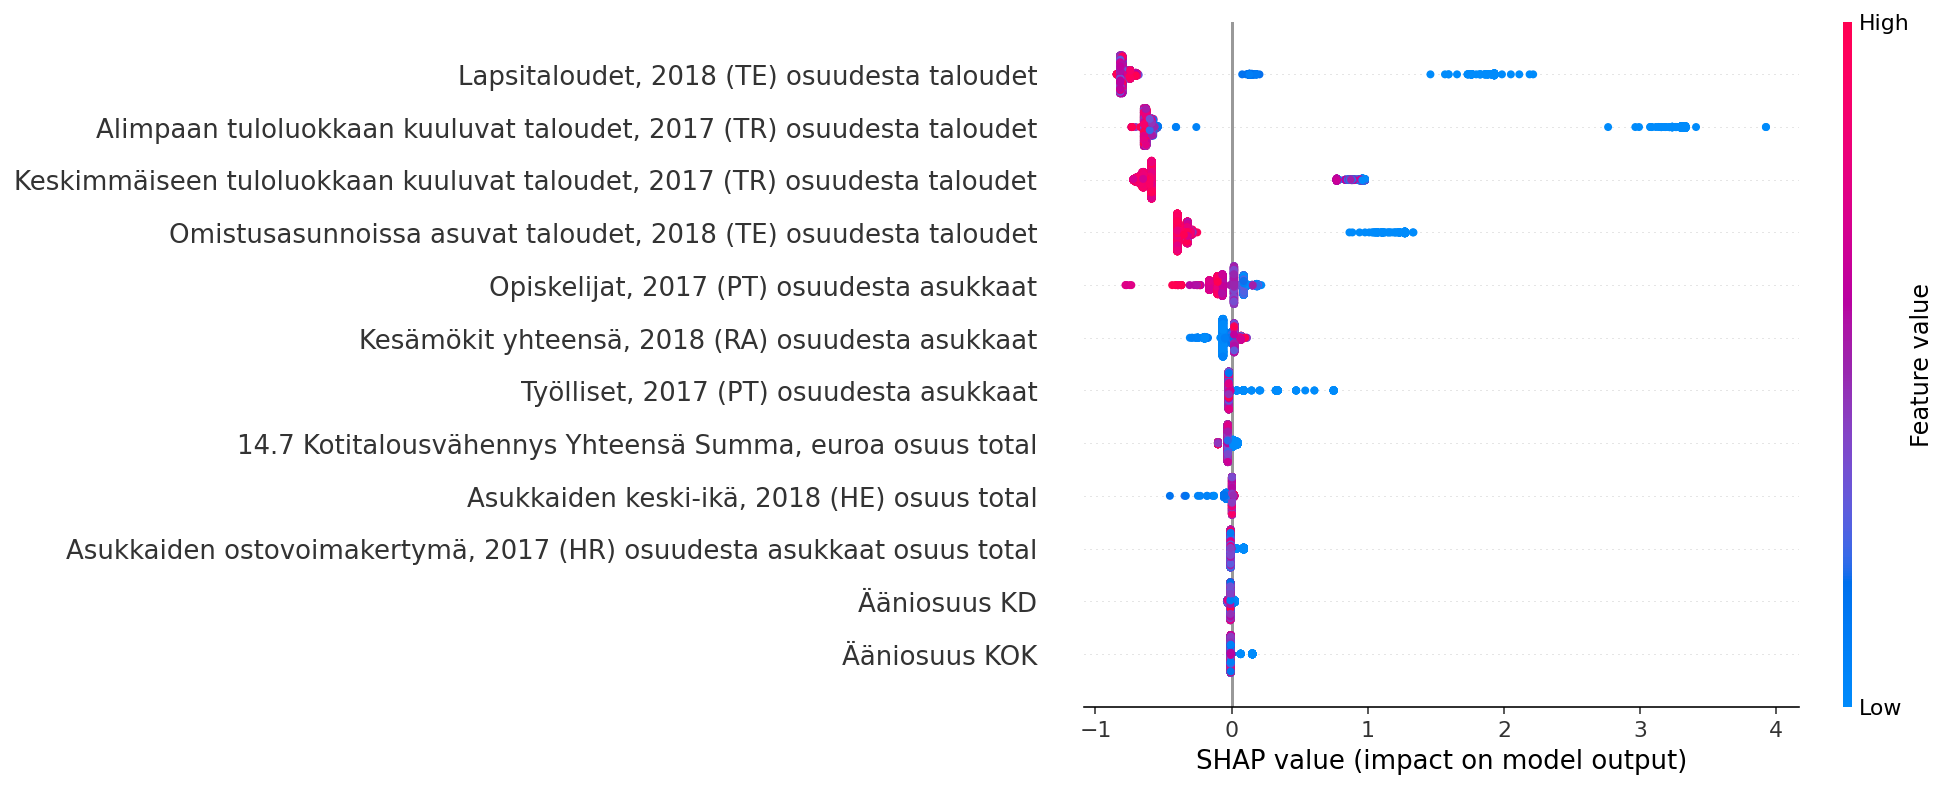

In [62]:
shap_index = 6
included_columns = []
columns = 12
scaled = False

compare_to = data[(data['cluster']) == shap_index].copy()
compare_to = create_share_of_values(compare_to)
compare_to = create_new_values(compare_to, vaalidata)

shap.summary_plot(shap_values[shap_index], X,  max_display=columns)

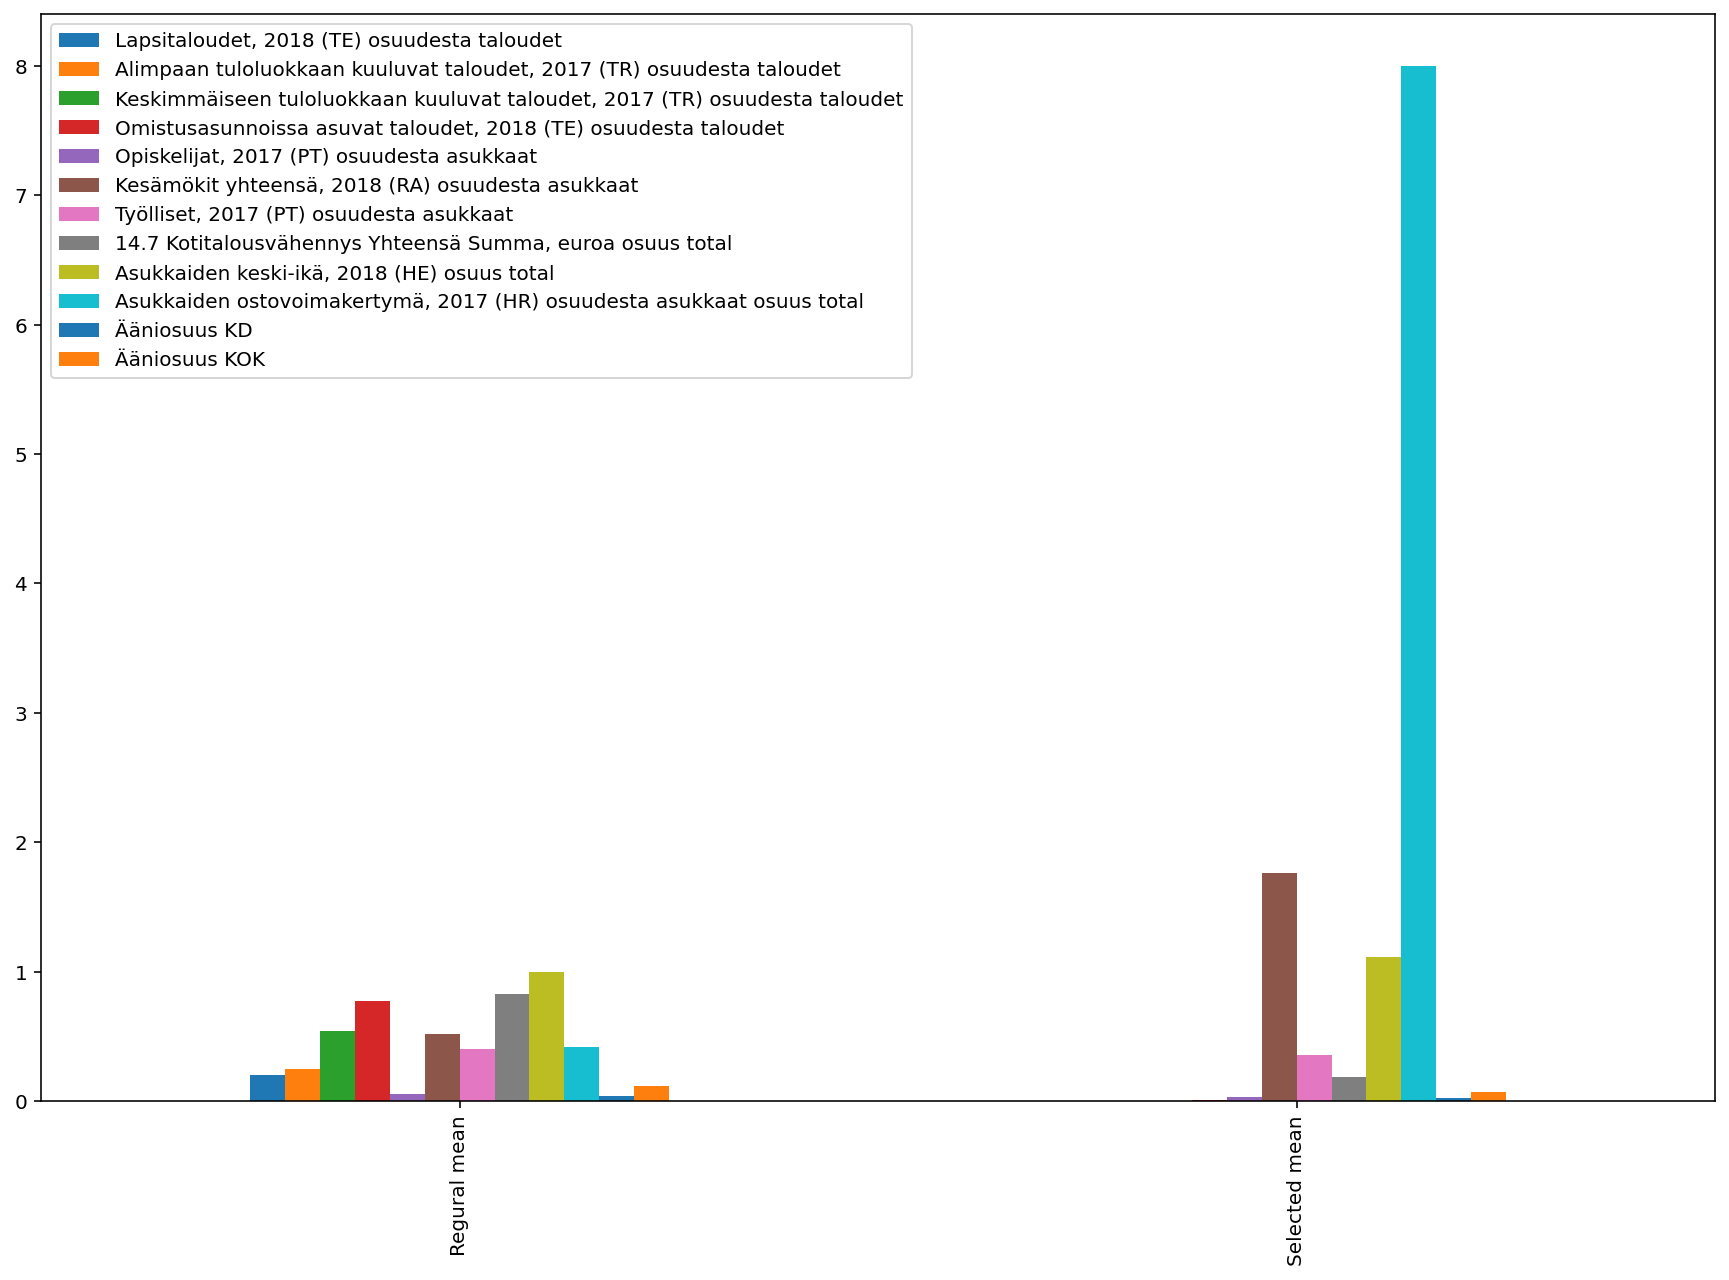

In [63]:
stats_data, k = plot_difference(data, compare_to, X, included_columns, shap_values, shap_index, col_num=columns, scaled=scaled)

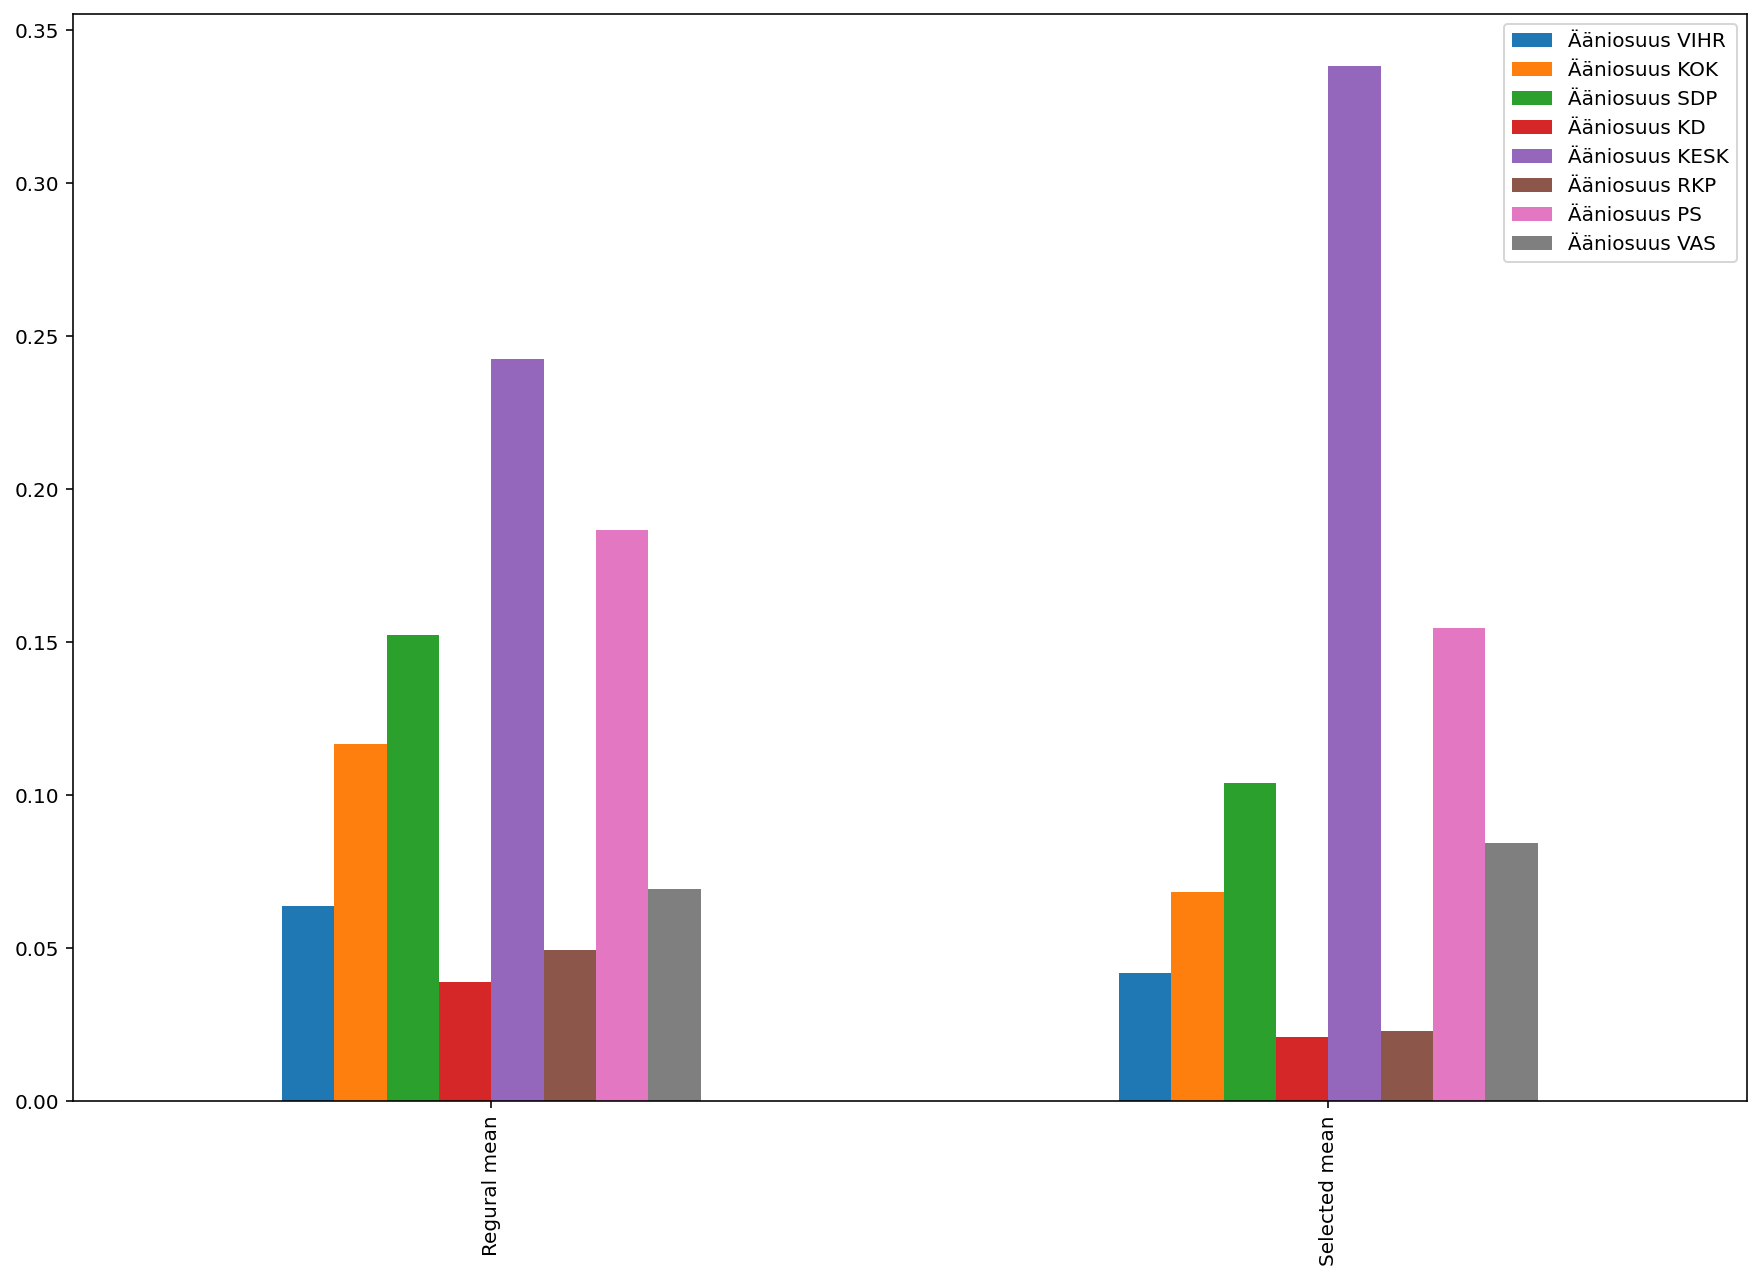

In [64]:
included_columns = all_included_columns
stats_data, k = plot_difference(data, compare_to, X, included_columns, shap_values, shap_index, col_num=0, scaled=False)

In [68]:
new = ['Postinumero','postcode_name', 'muncipality_name','Asukkaat yhteensä, 2018 (HE)', 'Suurin_puolue']
new_df, k2, col_list = create_example_df(compare_to, X, new, shap_index, shap_values, col_num=columns)
new_df.sample(5)

invalid value encountered in true_divide
invalid value encountered in true_divide


Postinumero postcode_name muncipality_name  Asukkaat yhteensä, 2018 (HE)  \
434        12820      RÄYSKÄLÄ            Loppi                          50.0   
2153       72220     ELIAKSELA            Tervo                          56.0   
2865       99135       RAUHALA          Kittilä                          23.0   
533        17710       TORITTU        Padasjoki                          61.0   
1448       49720      HURTTALA       Miehikkälä                          56.0   

     Suurin_puolue  Asukkaiden keski-ikä, 2018 (HE) osuus total  \
434           KESK                                     0.978768   
2153          KESK                                     1.065770   
2865          KESK                                     0.957018   
533            SDP                                     1.109271   
1448          KESK                                     1.109271   

      Asukkaiden ostovoimakertymä, 2017 (HR) osuudesta asukkaat osuus total  \
434                                                                0.013042   
2153                                                               0.012602   
2865                                                               3.630443   
533                                                                0.013658   
1448                                                               0.012270   

      Kesämökit yhteensä, 2018 (RA) osuudesta asukkaat  \
434                                           5.040000   
2153                                          1.339286   
2865                                          2.260870   
533                                           3.049180   
1448                                          0.767857   

      Työlliset, 2017 (PT) osuudesta asukkaat  \
434                                  0.400000   
2153                                 0.357143   
2865                                 0.434783   
533                                  0.327869   
1448                                 0.482143   

      Opiskelijat, 2017 (PT) osuudesta asukkaat  \
434                                    0.020000   
2153                                   0.053571   
2865                                   0.000000   
533                                    0.049180   
1448                                   0.053571   

      Lapsitaloudet, 2018 (TE) osuudesta taloudet  \
434                                           0.0   
2153                                          0.0   
2865                                          0.0   
533                                           0.0   
1448                                          0.0   

      Omistusasunnoissa asuvat taloudet, 2018 (TE) osuudesta taloudet  \
434                                                               0.0   
2153                                                              0.0   
2865                                                              0.0   
533                                                               0.0   
1448                                                              0.0   

      Alimpaan tuloluokkaan kuuluvat taloudet, 2017 (TR) osuudesta taloudet  \
434                                                                     0.0   
2153                                                                    0.0   
2865                                                                    0.0   
533                                                                     0.0   
1448                                                                    0.0   

      Keskimmäiseen tuloluokkaan kuuluvat taloudet, 2017 (TR) osuudesta taloudet  \
434                                                                          0.0   
2153                                                                         0.0   
2865                                                                         0.0   
533                                                                          0.0   
1448                                

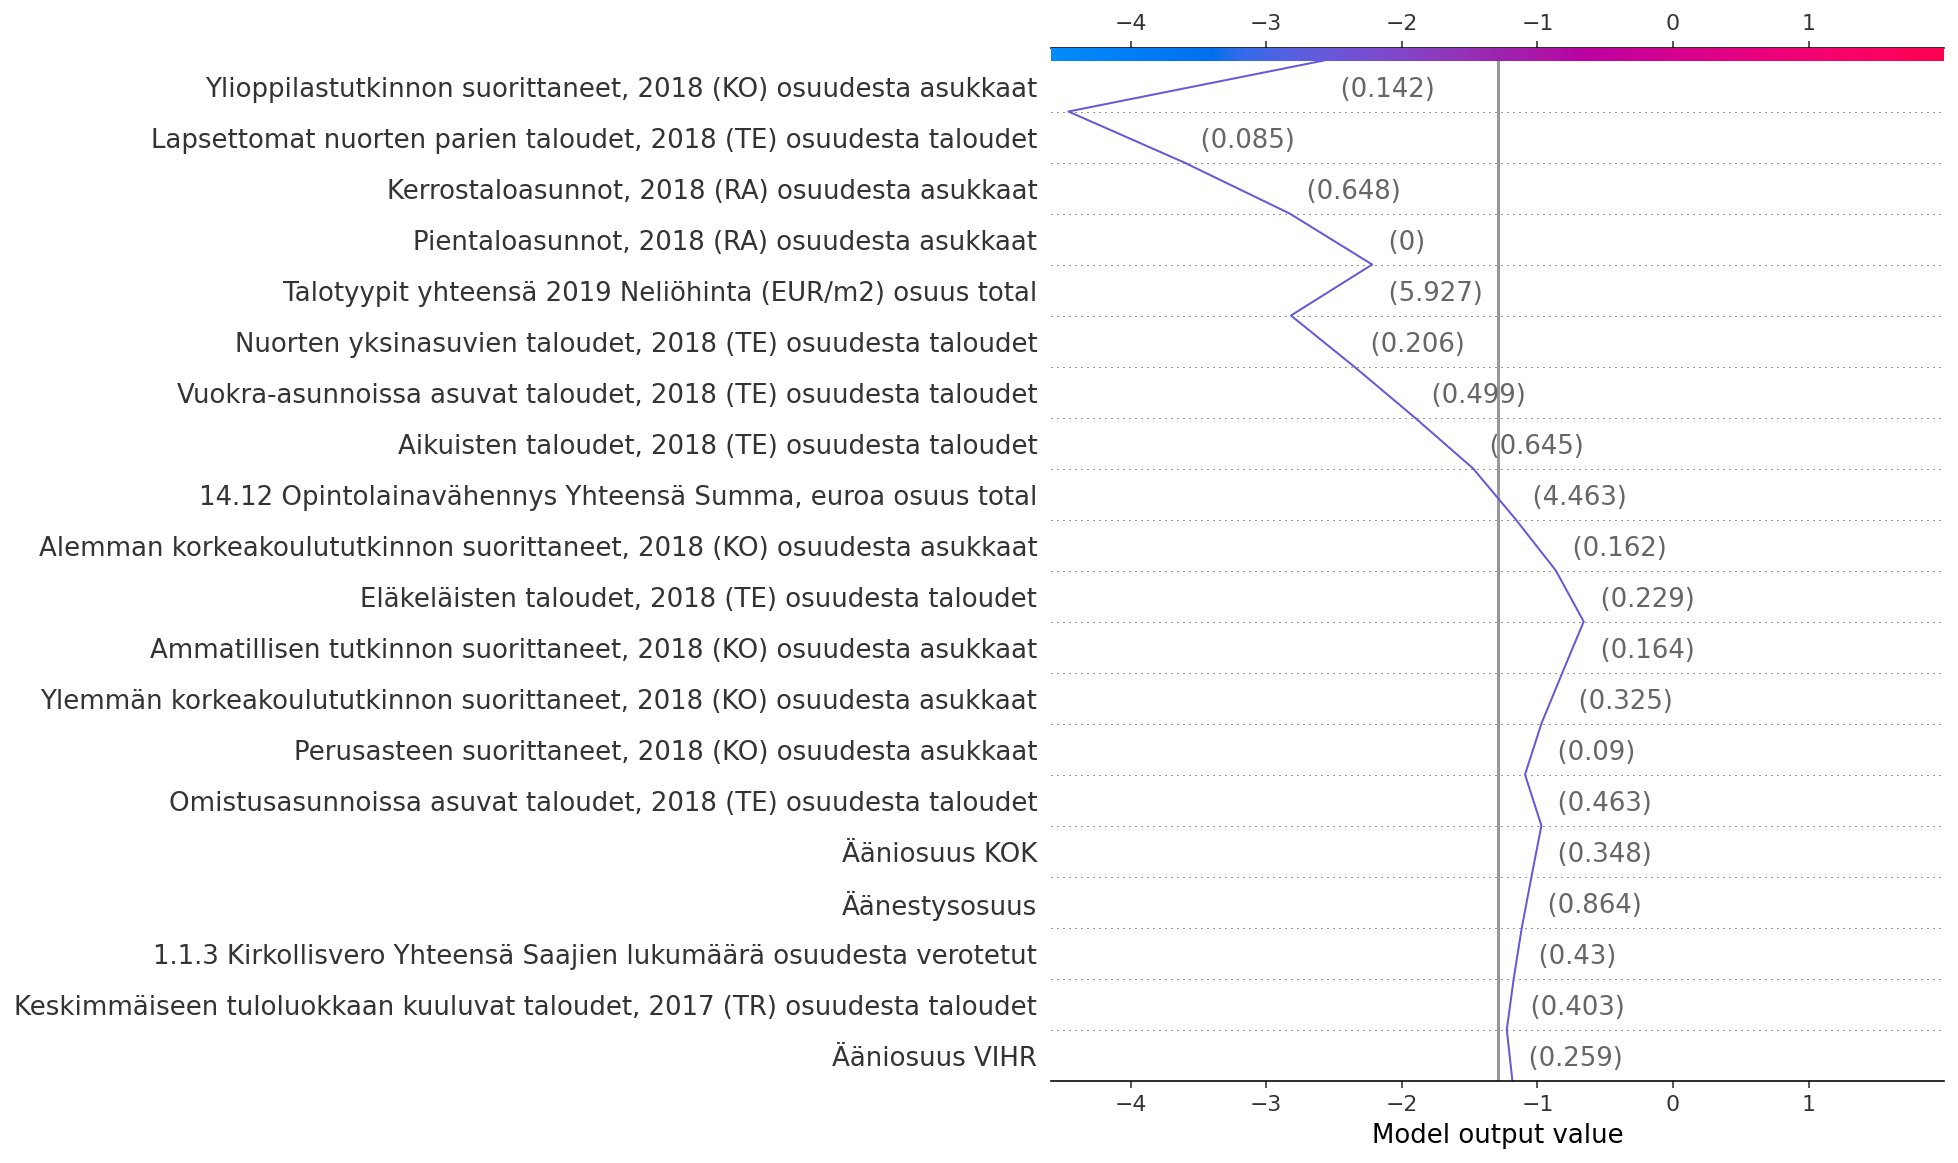

In [42]:
pnro = '02160'
id_col = 'Postinumero'
target='cluster'
idx = data[data[id_col]==pnro].index.item()
shap_index = data[data[id_col]==pnro][target].item()

shap.decision_plot(shap_expected_value[shap_index], shap_values[shap_index][idx], X)


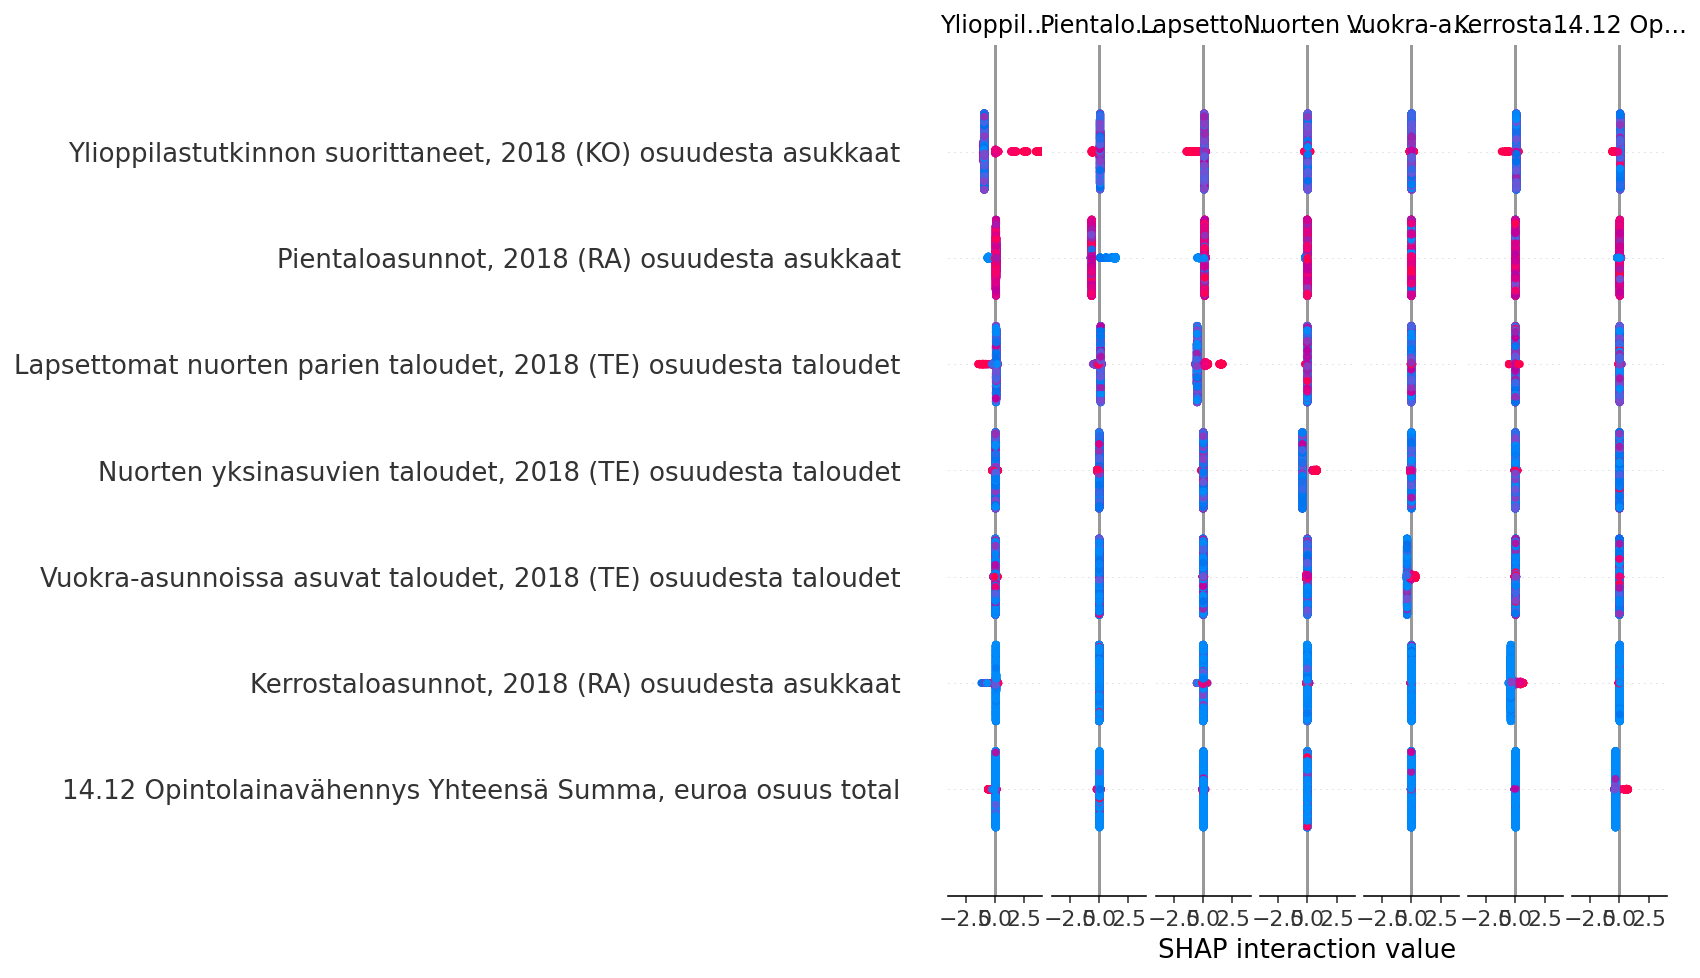

In [43]:
shap.summary_plot(shap_interaction_values[shap_index], X)